In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import json
import warnings
warnings.filterwarnings('ignore')


In [38]:
# Set plot style for better visuals
plt.style.use('ggplot')
sns.set_palette("viridis")

DATA_DIR = Path("../data")
NEO_DATA_DIR = DATA_DIR / "neo" / "raw"
ORBITAL_DIR = DATA_DIR / "neo" / "orbital"
AGGREGATIONS_DIR = DATA_DIR / "neo" / "aggregations"

# Find the latest files
neo_files = sorted(glob.glob(str(NEO_DATA_DIR / "neo_data_*.parquet")))
approaches_files = sorted(glob.glob(str(NEO_DATA_DIR / "neo_approaches_*.parquet")))
orbital_files = sorted(glob.glob(str(ORBITAL_DIR / "neo_orbital_*.parquet")))
aggregation_files = sorted(glob.glob(str(AGGREGATIONS_DIR / "neo_aggregations_*.parquet")))

# Print the files we found
print("Latest NEO data file:", neo_files[-1] if neo_files else "No file found")
print("Latest approaches file:", approaches_files[-1] if approaches_files else "No file found")
print("Latest orbital file:", orbital_files[-1] if orbital_files else "No file found")
print("Latest aggregation file:", aggregation_files[-1] if aggregation_files else "No file found")

# Load the data
neo_df = pd.read_parquet(neo_files[-1]) if neo_files else None
approaches_df = pd.read_parquet(approaches_files[-1]) if approaches_files else None
orbital_df = pd.read_parquet(orbital_files[-1]) if orbital_files else None
aggregation_df = pd.read_parquet(aggregation_files[-1]) if aggregation_files else None


# Convert approach_date to datetime for better analysis
approaches_df['approach_date'] = pd.to_datetime(approaches_df['approach_date'])
approaches_df['approach_year'] = approaches_df['approach_date'].dt.year
approaches_df['approach_month'] = approaches_df['approach_date'].dt.month

Latest NEO data file: ../data/neo/raw/neo_data_20250328_000704.parquet
Latest approaches file: ../data/neo/raw/neo_approaches_20250328_000704.parquet
Latest orbital file: ../data/neo/orbital/neo_orbital_20250328_000704.parquet
Latest aggregation file: ../data/neo/aggregations/neo_aggregations_20250328_000704.parquet


# EDA

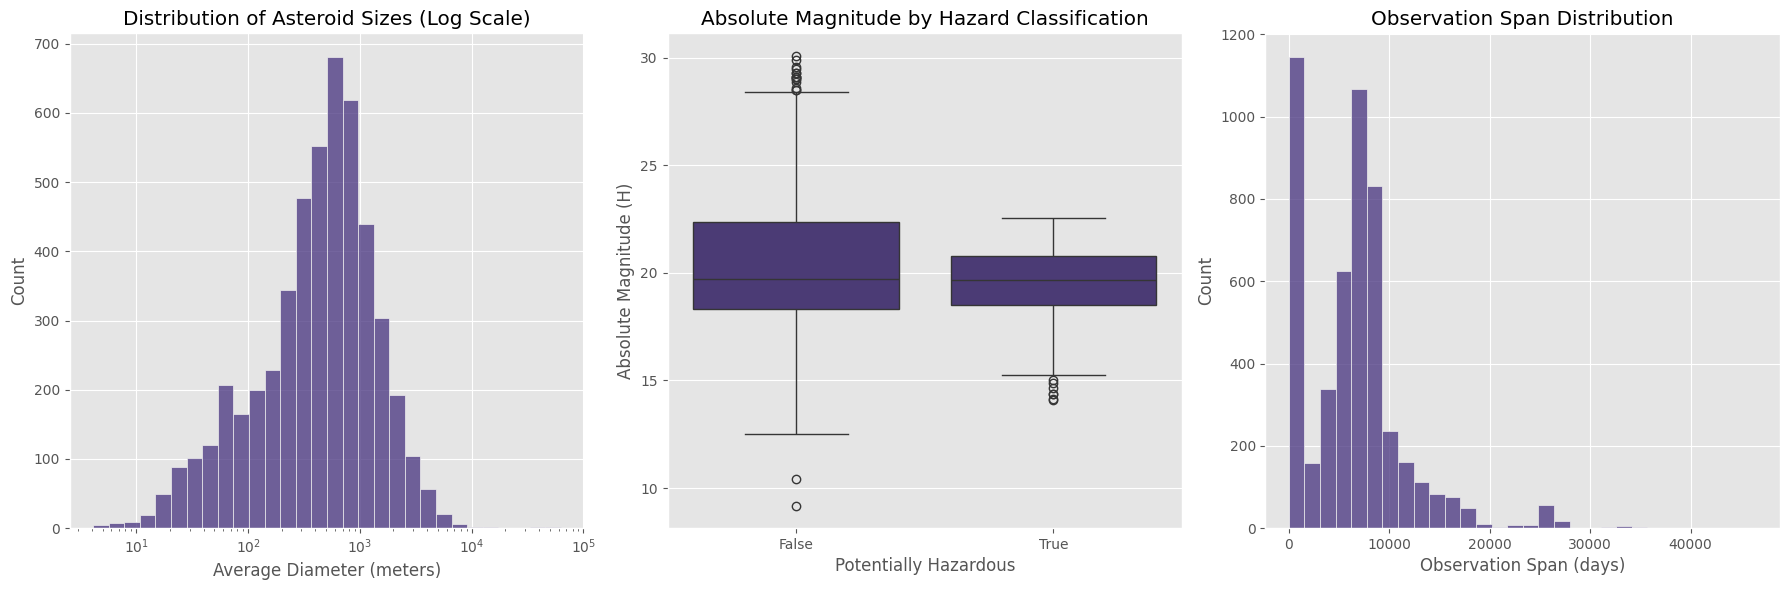

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Distribution of asteroid sizes (log scale for better visibility)
neo_df['avg_diameter'] = (neo_df['minimum_estimated_diameter_meters'] + neo_df['maximum_estimated_diameter_meters']) / 2
sns.histplot(neo_df['avg_diameter'], bins=30, log_scale=True, ax=axes[0])
axes[0].set_title('Distribution of Asteroid Sizes (Log Scale)')
axes[0].set_xlabel('Average Diameter (meters)')
axes[0].set_ylabel('Count')

# Hazardous vs non-hazardous asteroids and their magnitudes
sns.boxplot(x='is_potentially_hazardous_asteroid', y='absolute_magnitude_h', data=neo_df, ax=axes[1])
axes[1].set_title('Absolute Magnitude by Hazard Classification')
axes[1].set_xlabel('Potentially Hazardous')
axes[1].set_ylabel('Absolute Magnitude (H)')

# Observation history - how long have we been tracking these objects?
neo_df['observation_span_days'] = (pd.to_datetime(neo_df['last_observation_date']) - 
                                  pd.to_datetime(neo_df['first_observation_date'])).dt.days
sns.histplot(neo_df['observation_span_days'], bins=30, ax=axes[2])
axes[2].set_title('Observation Span Distribution')
axes[2].set_xlabel('Observation Span (days)')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

The left plot shows asteroid size distribution on a logarithmic scale, with most NEOs falling between 100-2000 meters in diameter, demonstrating the predominance of smaller objects in our dataset. The middle graph compares absolute magnitude (H) by hazard classification, revealing that potentially hazardous asteroids (True) tend to have lower H values (median around 19-20) than non-hazardous ones (median around 22), which makes sense as lower H values correspond to brighter, typically larger objects that pose greater threat if they were to impact Earth. The right plot displays observation span distribution, showing how long we've been tracking these objects, with most NEOs having been observed for less than 10,000 days (approximately 27 years), and a notable clustering under 5,000 days. This indicates that many objects in our dataset are relatively recent discoveries, though there's a small secondary cluster around 30,000 days representing NEOs that have been monitored for nearly a century.

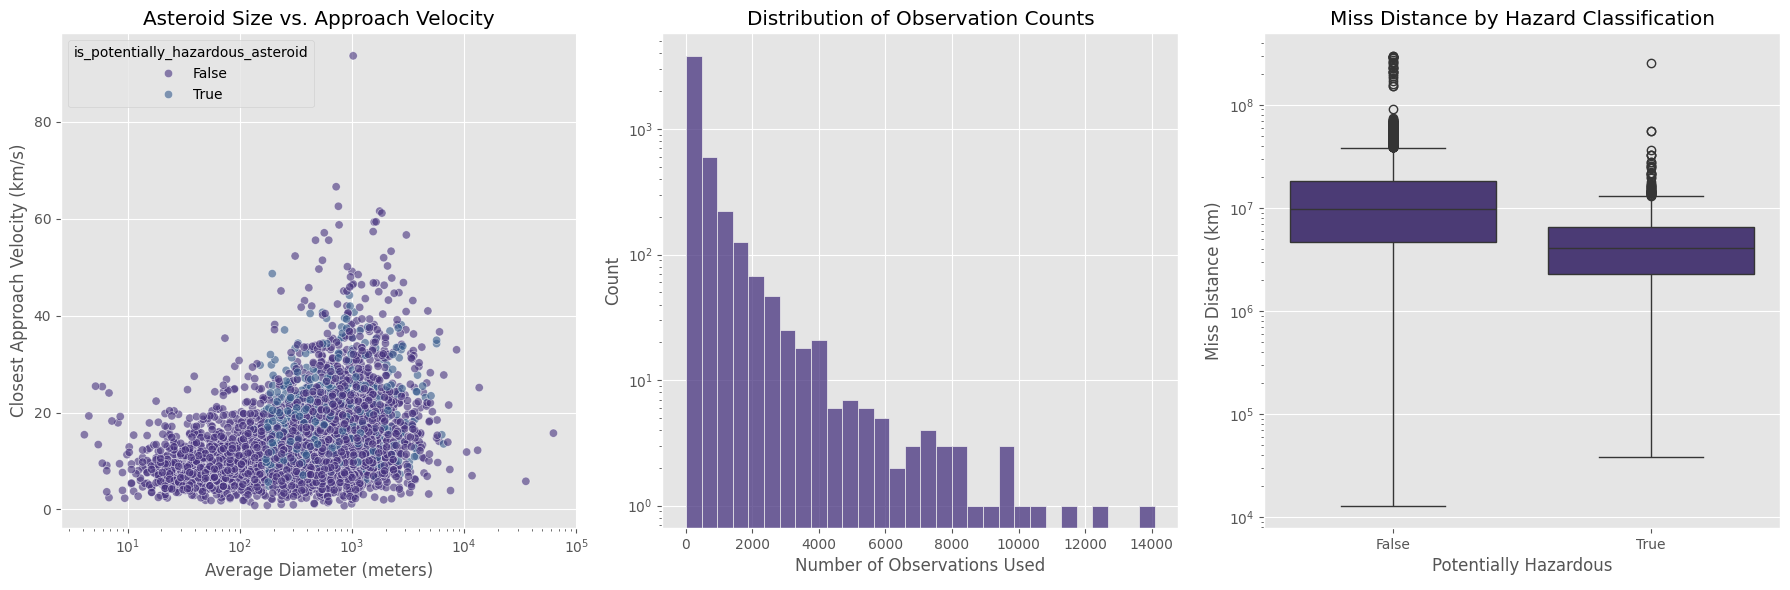

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Relationship between diameter and velocity at closest approach
sns.scatterplot(
    x='avg_diameter',
    y='closest_approach_relative_velocity_kps',
    hue='is_potentially_hazardous_asteroid',
    data=neo_df, 
    alpha=0.6,
    ax=axes[0]
)
axes[0].set_title('Asteroid Size vs. Approach Velocity')
axes[0].set_xlabel('Average Diameter (meters)')
axes[0].set_ylabel('Closest Approach Velocity (km/s)')
axes[0].set_xscale('log')  # Log scale for better visualization

# Observation count distribution
sns.histplot(neo_df['observations_used'], bins=30, ax=axes[1])
axes[1].set_title('Distribution of Observation Counts')
axes[1].set_xlabel('Number of Observations Used')
axes[1].set_ylabel('Count')
axes[1].set_yscale('log')  # Log scale to better see the distribution

# Compare miss distance by hazard classification
sns.boxplot(
    x='is_potentially_hazardous_asteroid', 
    y='closest_approach_miss_distance_kilometers',
    data=neo_df,
    ax=axes[2]
)
axes[2].set_title('Miss Distance by Hazard Classification')
axes[2].set_xlabel('Potentially Hazardous')
axes[2].set_ylabel('Miss Distance (km)')
axes[2].set_yscale('log')  # Log scale due to wide range of distances

plt.tight_layout()
plt.show()

The left plot shows the relationship between asteroid size and approach velocity, revealing that while there's considerable scatter, most NEOs cluster between 5-30 km/s regardless of size, with some mid-sized asteroids (100-2000m) reaching the highest velocities up to 60 km/s. The middle chart displays the distribution of observation counts on a logarithmic scale, demonstrating that the majority of NEOs have been observed fewer than 1000 times, with frequency rapidly decreasing as observation count increases - indicating most objects in our dataset have relatively limited observational history. The right plot compares miss distances by hazard classification on a logarithmic scale, showing that potentially hazardous asteroids (True) typically have closer approaches to Earth (median around 3-6 million km) than non-hazardous ones (median around 10-20 million km), which aligns with NASA's classification criteria that considers both size and proximity in determining hazard potential

In [41]:
# summary of null values and data ranges
null_counts = neo_df.isnull().sum()
value_ranges = pd.DataFrame({
    'min': neo_df.select_dtypes(include=[np.number]).min(),
    'max': neo_df.select_dtypes(include=[np.number]).max(),
    'mean': neo_df.select_dtypes(include=[np.number]).mean(),
    'null_count': null_counts[neo_df.select_dtypes(include=[np.number]).columns],
    'null_percentage': (null_counts[neo_df.select_dtypes(include=[np.number]).columns] / len(neo_df) * 100).round(2)
})

# For object columns, show null counts and unique values count
object_summary = pd.DataFrame({
    'unique_values': neo_df.select_dtypes(include=['object']).nunique(),
    'null_count': null_counts[neo_df.select_dtypes(include=['object']).columns],
    'null_percentage': (null_counts[neo_df.select_dtypes(include=['object']).columns] / len(neo_df) * 100).round(2),
    'example': neo_df.select_dtypes(include=['object']).iloc[0]
})

display(value_ranges)
display(object_summary)

,min,max,mean,null_count,null_percentage
absolute_magnitude_h,9.180000,3.010000e+01,2.019341e+01,0,0.00
minimum_estimated_diameter_meters,2.538370,3.877528e+04,4.566363e+02,0,0.00
maximum_estimated_diameter_meters,5.675969,8.670417e+04,1.021070e+03,0,0.00
closest_approach_miss_distance_kilometers,12913.138541,2.984463e+08,1.324001e+07,151,3.02
closest_approach_relative_velocity_kps,0.788867,9.364973e+01,1.415255e+01,151,3.02
observations_used,4.000000,1.409900e+04,4.555358e+02,0,0.00
avg_diameter,4.107169,6.273973e+04,7.388530e+02,0,0.00
observation_span_days,0.000000,4.658200e+04,6.374325e+03,0,0.00


,unique_values,null_count,null_percentage,example
id,5000,0,0.00,2000433
neo_reference_id,5000,0,0.00,2000433
name,5000,0,0.00,433 Eros (A898 PA)
name_limited,173,4827,96.54,Eros
designation,5000,0,0.00,433
nasa_jpl_url,5000,0,0.00,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...
closest_approach_date,4562,151,3.02,2137-01-25
first_observation_date,2771,0,0.00,1893-10-29
last_observation_date,2416,0,0.00,2021-05-13
orbital_period,5000,0,0.00,643.1403141999031


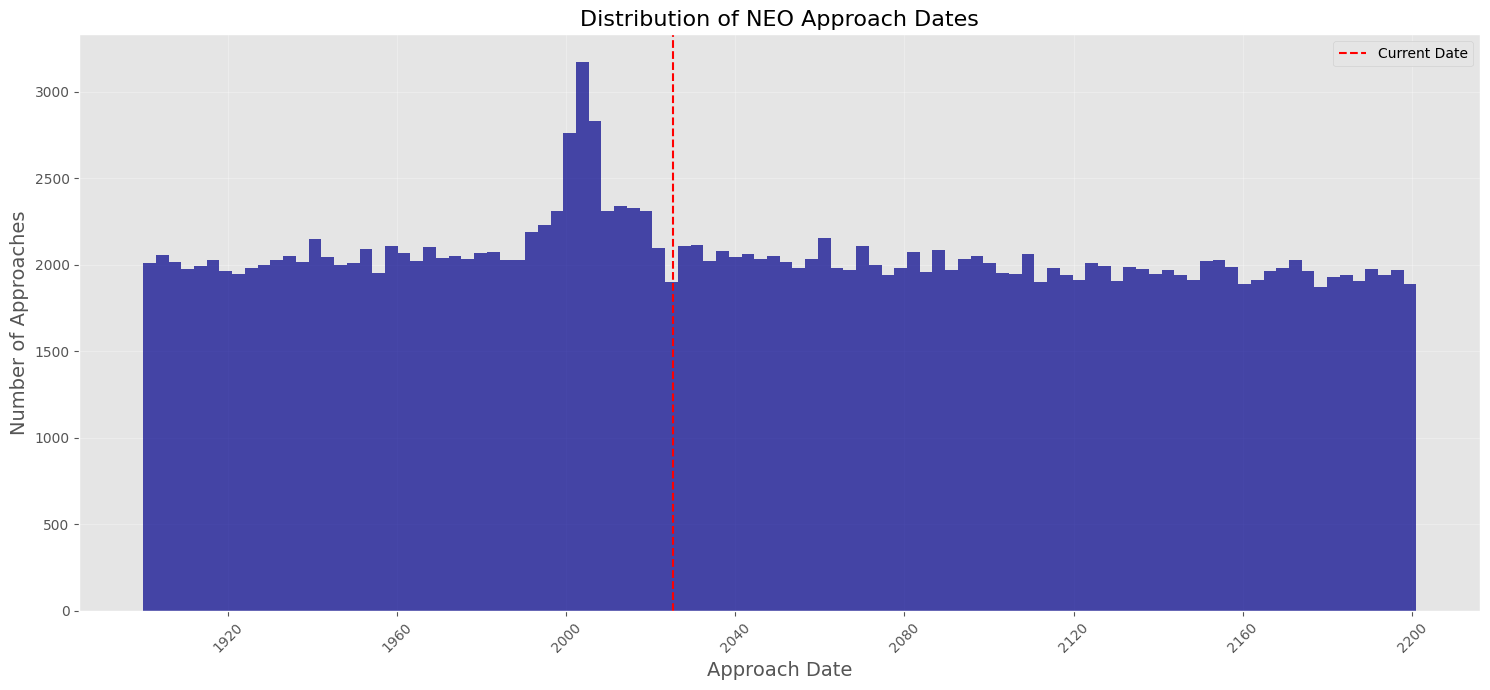

In [42]:
plt.figure(figsize=(15, 7))

# Create histogram of approach dates
plt.hist(approaches_df['approach_date'], bins=100, color='darkblue', alpha=0.7)

# Add vertical line for current date
plt.axvline(pd.to_datetime('today'), color='red', linestyle='--', label='Current Date')

# Format the plot
plt.title('Distribution of NEO Approach Dates', fontsize=16)
plt.xlabel('Approach Date', fontsize=14)
plt.ylabel('Number of Approaches', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Format x-axis to show dates clearly
plt.xticks(rotation=45)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print some statistics about the date range
min_date = approaches_df['approach_date'].min()
max_date = approaches_df['approach_date'].max()


The NEO approach date distribution reveals an interesting temporal pattern spanning from the early 1900s to the 2200s. The pronounced spike around 2000-2010 likely represents a period of intensive NEO discovery and cataloging efforts by NASA, followed by a natural decline as most detectable objects in certain size ranges were already captured. Importantly, dates before 2025 and after represent two different data types: retroactively calculated past approaches based on current orbital parameters, and predicted future approaches using the same physical models. This means astronomers have used the objects' current orbits to mathematically determine when they made close approaches to Earth historically, even if those approaches weren't observed at the time. For modeling purposes, this distinction is crucial - we should train our models on the historical calculations (pre-2025) and use NASA's predictions as a benchmark for our own forecast accuracy.

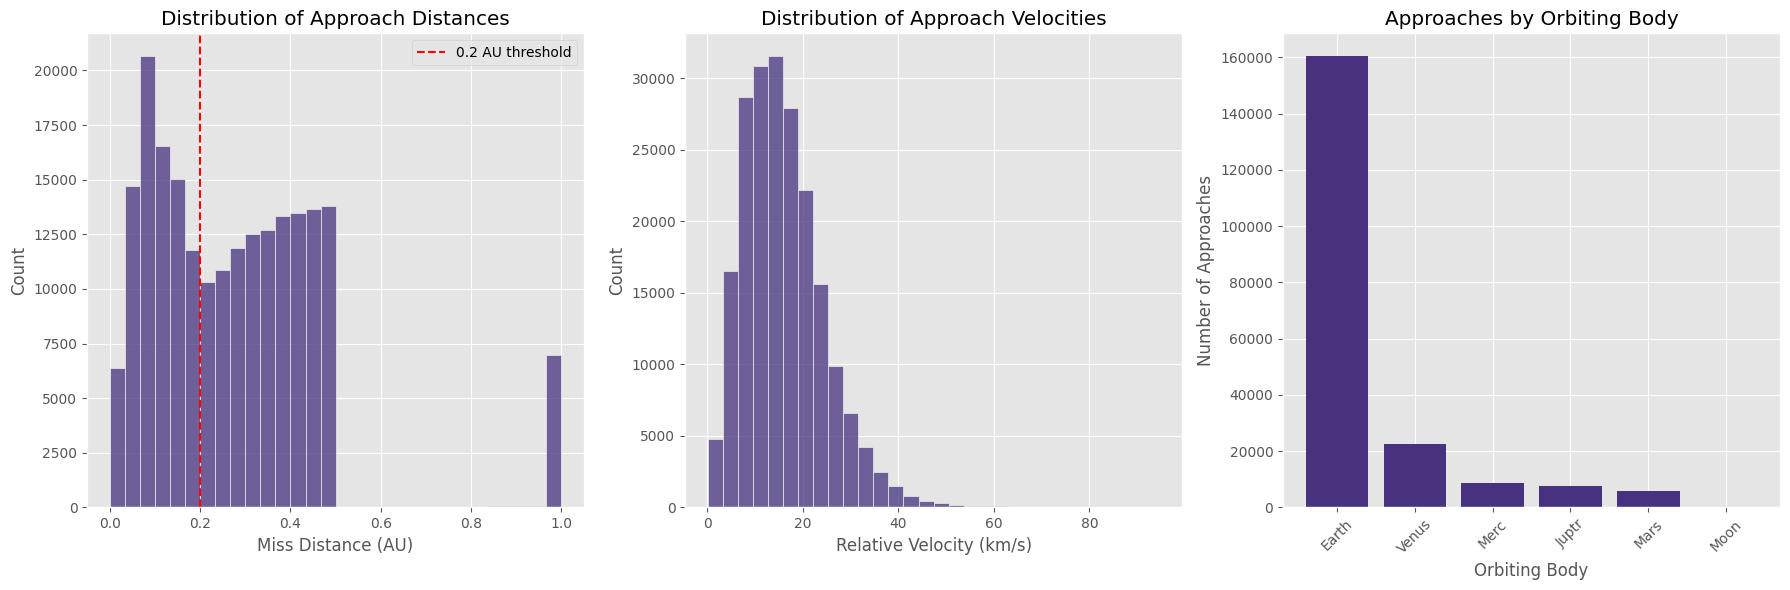

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Distribution of miss distances in AU
sns.histplot(approaches_df['miss_distance_au'].clip(upper=1), bins=30, ax=axes[0])
axes[0].axvline(x=0.2, color='r', linestyle='--', label='0.2 AU threshold')
axes[0].set_title('Distribution of Approach Distances')
axes[0].set_xlabel('Miss Distance (AU)')
axes[0].set_ylabel('Count')
axes[0].legend()

# Distribution of relative velocities
sns.histplot(approaches_df['relative_velocity_kps'], bins=30, ax=axes[1])
axes[1].set_title('Distribution of Approach Velocities')
axes[1].set_xlabel('Relative Velocity (km/s)')
axes[1].set_ylabel('Count')

# Approaches per orbiting body
approaches_by_body = approaches_df['orbiting_body'].value_counts()
axes[2].bar(approaches_by_body.index, approaches_by_body.values)
axes[2].set_title('Approaches by Orbiting Body')
axes[2].set_xlabel('Orbiting Body')
axes[2].set_ylabel('Number of Approaches')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The left plot displays the distribution of approach distances in Astronomical Units (AU), with a significant number of approaches occurring within 0.2 AU of Earth (marked by the red line), which is a key threshold for hazard assessment. The distribution shows several peaks, with the highest concentrations near 0.1 AU and between 0.3-0.5 AU, plus an interesting spike at 1.0 AU. The middle graph shows approach velocities clustering predominantly between 10-25 km/s, with a peak around 15 km/s, illustrating the typical speeds at which NEOs pass by Earth. The right chart reveals that the vast majority of recorded approaches are relative to Earth, which makes sense given the dataset's focus on Near-Earth Objects, with Venus having the second-highest count, followed by much smaller numbers of approaches to Mars, Mercury, Jupiter, and the Moon – reflecting both the orbital dynamics of these objects and our Earth-centric observation bias.

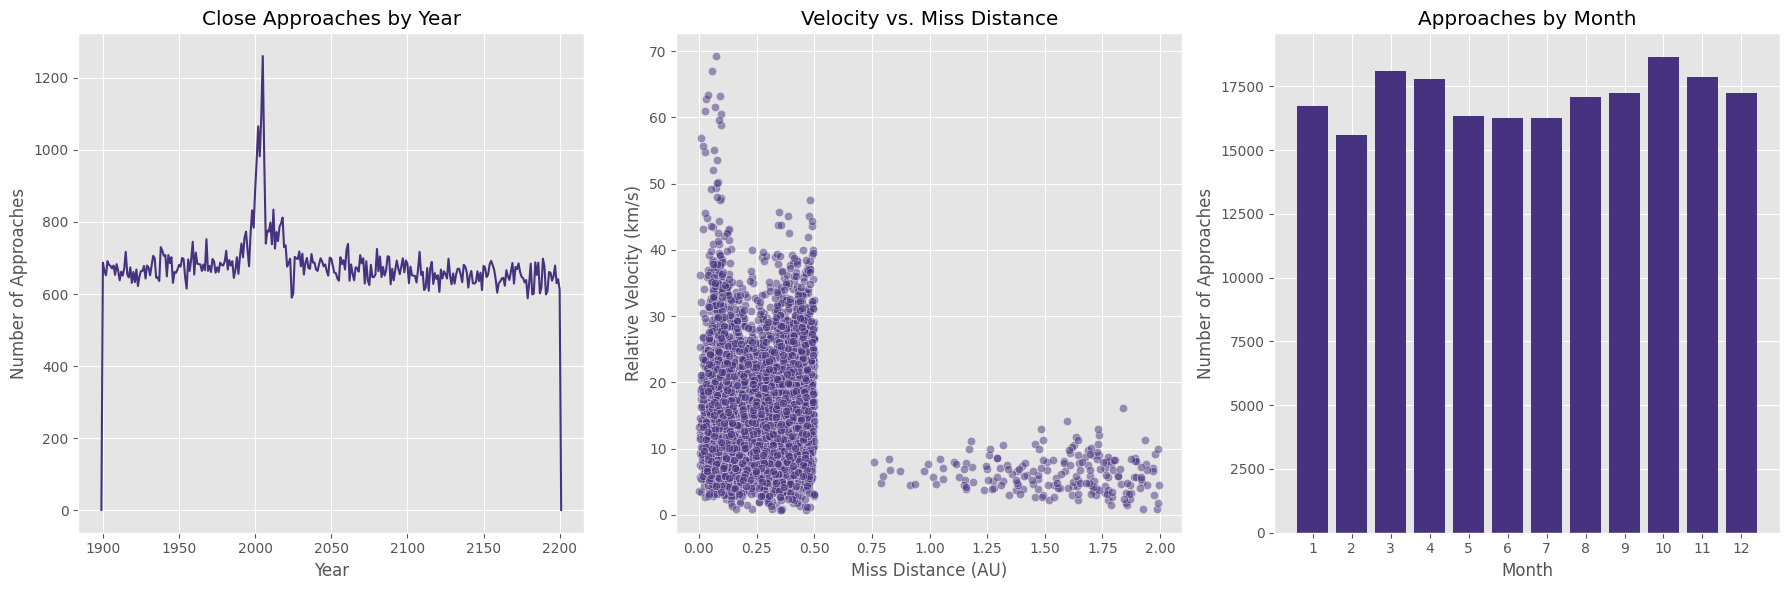

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Approaches over time by year
yearly_approaches = approaches_df['approach_year'].value_counts().sort_index()
axes[0].plot(yearly_approaches.index, yearly_approaches.values)
axes[0].set_title('Close Approaches by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Approaches')
axes[0].grid(True)

# Relationship between velocity and miss distance
sns.scatterplot(
    x='miss_distance_au', 
    y='relative_velocity_kps', 
    data=approaches_df.sample(5000) if len(approaches_df) > 5000 else approaches_df,  # Sample to avoid overcrowding
    alpha=0.5,
    ax=axes[1]
)
axes[1].set_title('Velocity vs. Miss Distance')
axes[1].set_xlabel('Miss Distance (AU)')
axes[1].set_ylabel('Relative Velocity (km/s)')

# Monthly pattern of approaches
monthly_approaches = approaches_df['approach_month'].value_counts().sort_index()
axes[2].bar(monthly_approaches.index, monthly_approaches.values)
axes[2].set_title('Approaches by Month')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Number of Approaches')
axes[2].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

The left graph shows close approaches by year from 1900 to 2200, with a striking spike around 2010-2020 that doesn't align with our expectation for calculated orbital approaches, which should be relatively consistent across time periods. This anomaly likely represents a methodological difference in how NASA recorded or calculated approaches during this specific period, rather than an actual increase in NEO activity. The middle plot reveals a fascinating relationship between velocity and miss distance, with a clear pattern showing higher velocities (up to 70 km/s) concentrated at very close distances (<0.25 AU), while approaches beyond 0.5 AU consistently show much lower velocities (generally below 15 km/s) - suggesting orbital mechanics may link closer approaches with higher relative velocities. The right chart displays the monthly distribution of approaches, showing a relatively even distribution throughout the year with slight peaks in March, October, and November, and a small dip in February - indicating minimal seasonal patterns in NEO approaches and suggesting that Earth's position in its orbit doesn't strongly influence the timing of close approaches in this dataset.

In [45]:
# Quick summary of null values and data ranges for approaches dataset
null_counts = approaches_df.isnull().sum()
null_percentage = (null_counts / len(approaches_df) * 100).round(2)

# For numeric columns
numeric_cols = approaches_df.select_dtypes(include=[np.number]).columns
numeric_summary = pd.DataFrame({
    'min': approaches_df[numeric_cols].min(),
    'max': approaches_df[numeric_cols].max(),
    'mean': approaches_df[numeric_cols].mean(),
    'median': approaches_df[numeric_cols].median(),
    'null_count': null_counts[numeric_cols],
    'null_percentage': null_percentage[numeric_cols]
})

# For object columns
object_cols = approaches_df.select_dtypes(include=['object']).columns
object_summary = pd.DataFrame({
    'unique_values': approaches_df[object_cols].nunique(),
    'null_count': null_counts[object_cols],
    'null_percentage': null_percentage[object_cols],
    'example': approaches_df[object_cols].iloc[0]
})

# For datetime columns
datetime_cols = approaches_df.select_dtypes(include=['datetime64']).columns
if not datetime_cols.empty:
    datetime_summary = pd.DataFrame({
        'min_date': approaches_df[datetime_cols].min(),
        'max_date': approaches_df[datetime_cols].max(),
        'null_count': null_counts[datetime_cols],
        'null_percentage': null_percentage[datetime_cols]
    })
    display(datetime_summary)

display(numeric_summary)
display(object_summary)

# Number of approaches per NEO
approaches_per_neo = approaches_df['neo_id'].value_counts()
approaches_stats = {
    'min_approaches': approaches_per_neo.min(),
    'max_approaches': approaches_per_neo.max(),
    'mean_approaches': approaches_per_neo.mean(),
    'median_approaches': approaches_per_neo.median(),
    'total_unique_neos': approaches_per_neo.count(),
    'total_approaches': len(approaches_df)
}
pd.DataFrame([approaches_stats])

,min_date,max_date,null_count,null_percentage
approach_date,1899-12-31,2201-01-02,0,0.0


,min,max,mean,median,null_count,null_percentage
miss_distance_km,12913.138541,2.991885e+08,4.448170e+07,3.821858e+07,0,0.0
miss_distance_au,0.000086,1.999952e+00,2.973418e-01,2.554754e-01,0,0.0
relative_velocity_kps,0.074507,9.468991e+01,1.601674e+01,1.479035e+01,0,0.0
approach_year,1899.000000,2.201000e+03,2.047777e+03,2.045000e+03,0,0.0
approach_month,1.000000,1.200000e+01,6.571389e+00,7.000000e+00,0,0.0


,unique_values,null_count,null_percentage,example
neo_id,4849,0,0.0,2000433
orbiting_body,6,0,0.0,Earth


,min_approaches,max_approaches,mean_approaches,median_approaches,total_unique_neos,total_approaches
0,1,473,42.297793,23.0,4849,205102


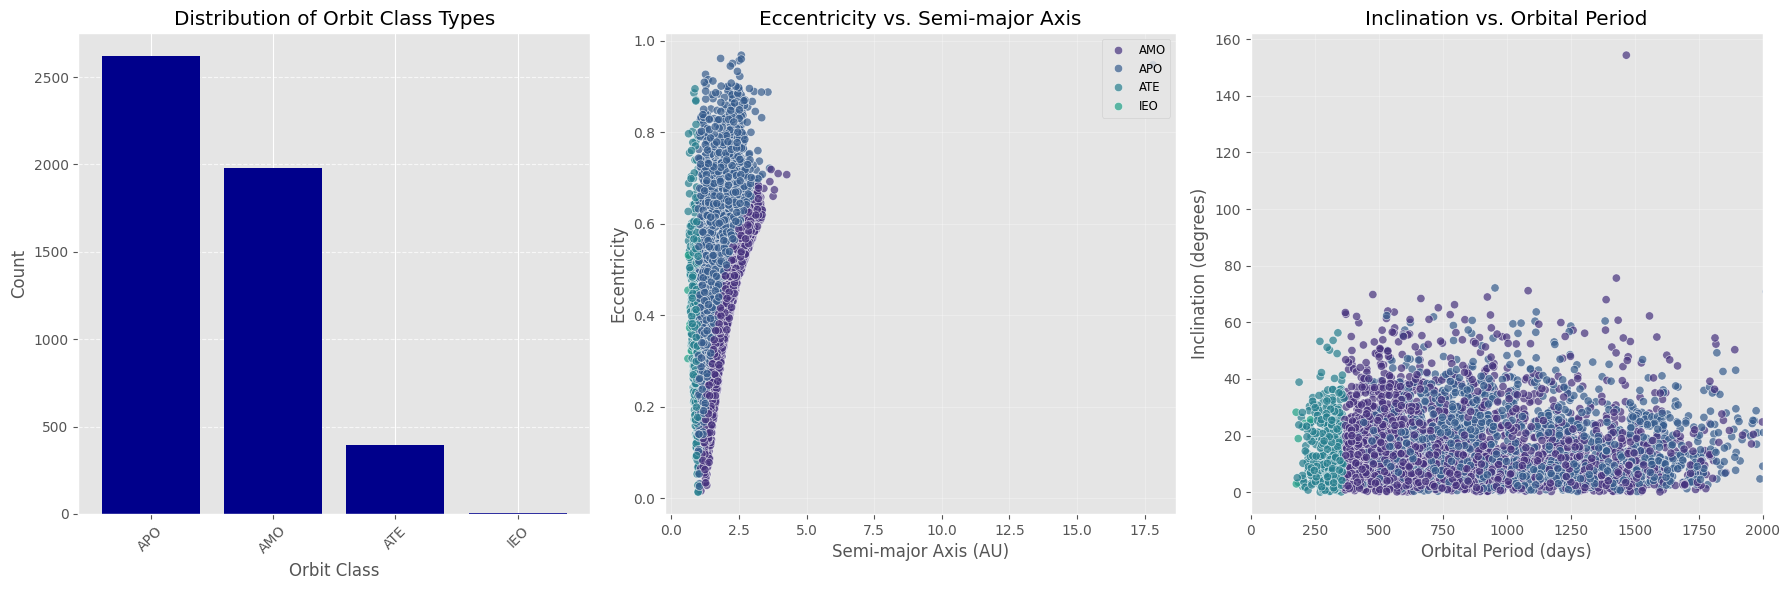

In [46]:
# Convert string columns to numeric where needed
numeric_cols = [
    'eccentricity', 'semi_major_axis', 'inclination', 'ascending_node_longitude',
    'orbital_period', 'perihelion_distance', 'perihelion_argument', 
    'aphelion_distance', 'mean_anomaly', 'mean_motion'
]

for col in numeric_cols:
    if col in orbital_df.columns:
        orbital_df[col] = pd.to_numeric(orbital_df[col], errors='coerce')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Distribution of orbital types
orbit_counts = orbital_df['orbit_class_type'].value_counts()
axes[0].bar(orbit_counts.index, orbit_counts.values, color='darkblue')
axes[0].set_title('Distribution of Orbit Class Types')
axes[0].set_xlabel('Orbit Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Eccentricity vs. Semi-major Axis
sns.scatterplot(
    x='semi_major_axis', 
    y='eccentricity',
    hue='orbit_class_type',
    data=orbital_df.sample(min(5000, len(orbital_df))),  # Sample to avoid overcrowding
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title('Eccentricity vs. Semi-major Axis')
axes[1].set_xlabel('Semi-major Axis (AU)')
axes[1].set_ylabel('Eccentricity')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper right', fontsize='small')

# Inclination vs. Orbital Period
sns.scatterplot(
    x='orbital_period', 
    y='inclination',
    hue='orbit_class_type',
    data=orbital_df.sample(min(5000, len(orbital_df))),  # Sample to avoid overcrowding
    alpha=0.7,
    ax=axes[2]
)
axes[2].set_title('Inclination vs. Orbital Period')
axes[2].set_xlabel('Orbital Period (days)')
axes[2].set_ylabel('Inclination (degrees)')
axes[2].set_xlim(0, 2000)  # Focus on more common orbital periods
axes[2].grid(True, alpha=0.3)
axes[2].legend([],[], frameon=False)  # Remove legend since it's in plot 2

plt.tight_layout()
plt.show()


The first plot reveals that Apollo (APO) NEOs dominate our dataset at over 2,500 objects, followed closely by Amor (AMO) asteroids at nearly 2,000, while Aten (ATE) objects are much less common at around 400, and Interior Earth Objects (IEO) are extremely rare. The middle graph shows a distinct relationship between eccentricity and semi-major axis, with most NEOs concentrated at semi-major axes below 3 AU and following a pattern where objects with larger semi-major axes tend to have higher eccentricities, forming a curved boundary that likely represents the orbital dynamics constraints for Earth-crossing asteroids. The right plot displays inclination versus orbital period, showing a wide scatter of inclinations (mostly below 40 degrees) across orbital periods up to 2000 days, with IEO objects (green) clustered at short periods and low inclinations, while one extreme outlier has an inclination approaching 160 degrees, indicating a highly unusual, nearly retrograde orbit.

Eccentricity and inclination are two fundamental parameters that describe an asteroid's orbit. Eccentricity measures how much an orbit deviates from being perfectly circular, with 0 representing a perfect circle and values approaching 1 indicating increasingly elongated elliptical orbits. In our dataset, most NEOs have eccentricities between 0.2 and 0.7, meaning they have moderately to highly elliptical orbits that bring them closer to Earth at certain points. Inclination measures the tilt of an asteroid's orbital plane relative to Earth's orbital plane (the ecliptic), expressed in degrees. An inclination of 0° means the asteroid orbits in the same plane as Earth, while values approaching 90° indicate more steeply tilted orbits, and the rare values above 90° (like our 160° outlier) represent retrograde orbits moving in the opposite direction to most solar system objects. Higher inclinations make asteroids harder to detect and track from Earth.


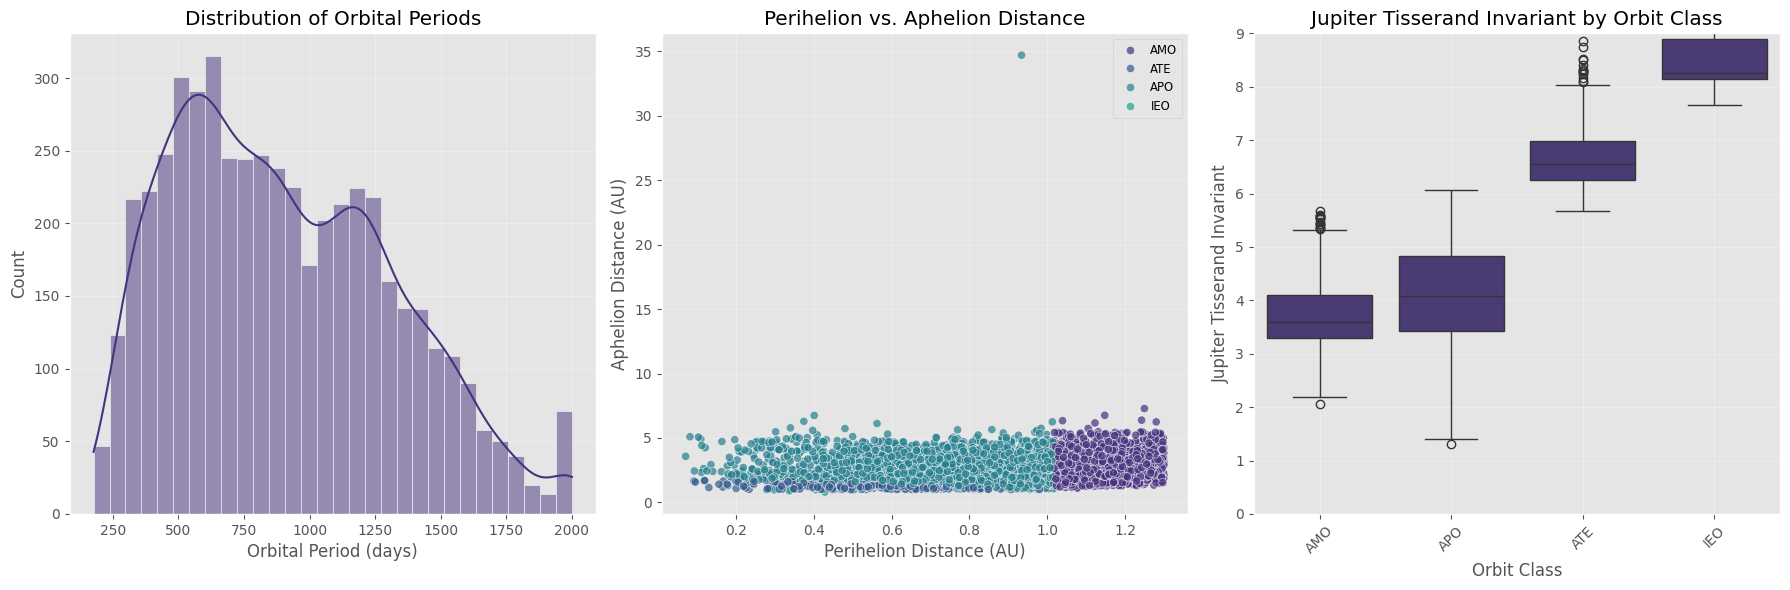

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Distribution of Orbital Periods
sns.histplot(
    orbital_df['orbital_period'].clip(upper=2000),  # Clip to focus on more common values
    bins=30,
    kde=True,
    ax=axes[0]
)
axes[0].set_title('Distribution of Orbital Periods')
axes[0].set_xlabel('Orbital Period (days)')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

# Perihelion vs. Aphelion Distance
sns.scatterplot(
    x='perihelion_distance', 
    y='aphelion_distance',
    hue='orbit_class_type',
    data=orbital_df.sample(min(5000, len(orbital_df))),  # Sample to avoid overcrowding
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title('Perihelion vs. Aphelion Distance')
axes[1].set_xlabel('Perihelion Distance (AU)')
axes[1].set_ylabel('Aphelion Distance (AU)')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper right', fontsize='small')

# Jupiter Tisserand Invariant distribution by orbit class
# First, ensure the column is numeric
orbital_df['jupiter_tisserand_invariant_numeric'] = pd.to_numeric(orbital_df['jupiter_tisserand_invariant'], errors='coerce')

# Now use manual y-limits instead of IQR calculation
sns.boxplot(
    x='orbit_class_type',
    y='jupiter_tisserand_invariant_numeric',
    data=orbital_df,
    ax=axes[2]
)
axes[2].set_title('Jupiter Tisserand Invariant by Orbit Class')
axes[2].set_xlabel('Orbit Class')
axes[2].set_ylabel('Jupiter Tisserand Invariant')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

# Set fixed y-limits based on what we can see in the original plot
axes[2].set_ylim(0, 9)  # Adjust these values as needed to focus on the main distribution

plt.tight_layout()
plt.show()

The orbital period distribution on the left shows a bimodal pattern with peaks around 500-600 days and again at 1100 days, suggesting two distinct populations of NEOs with different orbital characteristics. The middle plot reveals the relationship between perihelion distance (closest approach to the Sun) and aphelion distance (farthest point), with most objects having perihelia between 0.2-1.2 AU and aphelia below 5 AU, though a few outliers reach aphelia up to 35 AU; additionally, the plot shows clear orbit-class separations, with ATEs (cyan) having perihelia <1 AU but mostly staying close to Earth's orbit, Apollos (blue) crossing Earth's orbit with perihelia <1.017 AU, and Amors (purple) concentrated at perihelia >1 AU. The rightmost graph displays the Jupiter Tisserand Invariant (JTI) – a parameter measuring orbital interaction with Jupiter – by orbit class, revealing a clear progression with AMO and APO asteroids typically having lower values (2-5), ATEs having intermediate values (6-7), and IEOs having the highest values (>8); this pattern reflects how orbit class relates to Jupiter's gravitational influence, with higher JTI values indicating orbits less perturbed by Jupiter, typical of objects that remain closer to the inner solar system.

Perihelion and aphelion represent the extremes of an asteroid's elliptical orbit around the Sun. Perihelion is the point where the object is closest to the Sun, while aphelion is the farthest point in its orbit. These measurements, typically expressed in Astronomical Units (AU), are crucial for understanding an asteroid's orbit and potential Earth-crossing behavior. The Jupiter Tisserand Invariant (JTI) is a complex parameter derived from celestial mechanics that measures how an object's orbit relates to Jupiter's gravitational influence. It remains approximately constant even as an orbit evolves over time due to planetary perturbations. A JTI value below 3 typically indicates a Jupiter-family comet orbit, values between 3-5 suggest asteroid orbits that still experience significant Jupiter influence, and values above 5 indicate orbits that remain largely decoupled from Jupiter's effects. This parameter helps astronomers classify objects and understand their dynamical history and future evolution in the solar system.

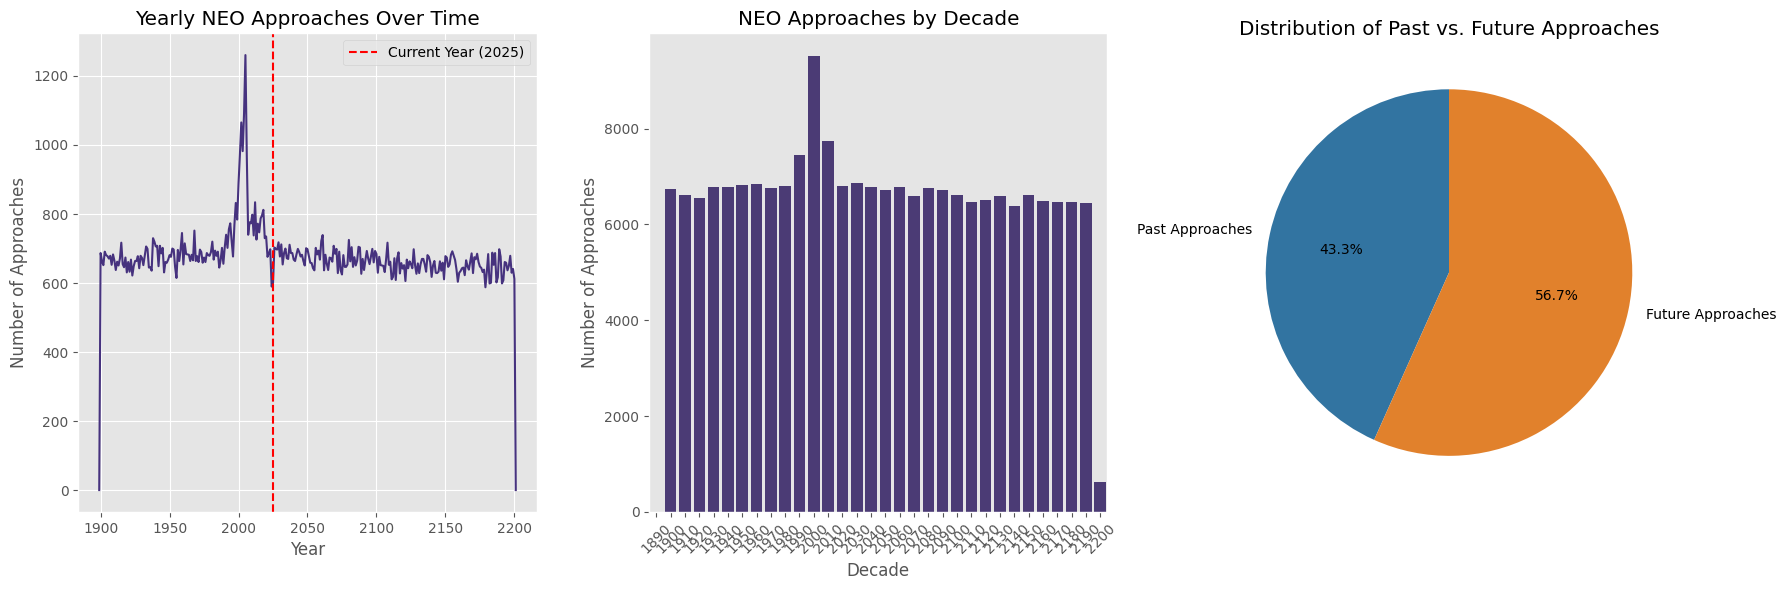

Total NEOs collected: 5000
NEOs with approaches closer than 0.2 AU: 4357
Percentage of NEOs with close approaches: 87.1%


In [48]:
# Parse the yearly approaches from JSON
yearly_data = json.loads(aggregation_df['yearly_approaches'].iloc[0])
years = list(yearly_data.keys())
approaches = list(yearly_data.values())

# Convert to DataFrame for easier plotting
yearly_df = pd.DataFrame({
    'year': [int(year) for year in years],
    'approaches': approaches
})
yearly_df = yearly_df.sort_values('year')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Yearly approaches over time
sns.lineplot(
    x='year', 
    y='approaches', 
    data=yearly_df,
    ax=axes[0]
)
axes[0].set_title('Yearly NEO Approaches Over Time')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Approaches')
axes[0].grid(True)

# Add vertical line for current year
axes[0].axvline(x=2025, color='red', linestyle='--', label='Current Year (2025)')
axes[0].legend()

# Distribution of approach counts by decade
yearly_df['decade'] = (yearly_df['year'] // 10) * 10
decade_counts = yearly_df.groupby('decade')['approaches'].sum().reset_index()

sns.barplot(
    x='decade',
    y='approaches',
    data=decade_counts,
    ax=axes[1]
)
axes[1].set_title('NEO Approaches by Decade')
axes[1].set_xlabel('Decade')
axes[1].set_ylabel('Number of Approaches')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y')

# Pie chart of approaches distribution (past/future)
current_year = 2025
past_approaches = yearly_df[yearly_df['year'] < current_year]['approaches'].sum()
future_approaches = yearly_df[yearly_df['year'] >= current_year]['approaches'].sum()

axes[2].pie(
    [past_approaches, future_approaches],
    labels=['Past Approaches', 'Future Approaches'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#3274A1', '#E1812C']
)
axes[2].set_title('Distribution of Past vs. Future Approaches')

plt.tight_layout()
plt.show()

# Display key metrics from the aggregation data
print(f"Total NEOs collected: {aggregation_df['total_neos_collected'].iloc[0]}")
print(f"NEOs with approaches closer than 0.2 AU: {aggregation_df['neos_closer_than_0.2_au'].iloc[0]}")
print(f"Percentage of NEOs with close approaches: {aggregation_df['neos_closer_than_0.2_au'].iloc[0]/aggregation_df['total_neos_collected'].iloc[0]*100:.1f}%")

The left plot shows a pronounced spike in NEO approaches around 2000-2020, followed by a return to baseline levels of approximately 650-700 approaches per year for both past and predicted future periods. The middle chart breaks down approaches by decade, revealing that while most decades show consistent approach counts between 6,000-7,000, the 2000s and 2010s stand out with significantly higher numbers, particularly the 2010s with over 9,000 recorded approaches. The pie chart on the right illustrates that 43.3% of all recorded approaches have already occurred (past approaches), while 56.7% represent future predicted approaches based on orbital calculations, indicating that the dataset contains more future predictions than historical data.

The aggregation_df differs from the other dataframes by serving as a summary statistics repository rather than containing individual records. While neo_df stores information about individual asteroids, approaches_df contains each close approach event, and orbital_df holds detailed orbital parameters, the aggregation_df instead stores pre-calculated metrics like total counts, yearly distributions, and threshold statistics derived from analyzing the other datasets.

The spike in NEO approaches around 2000-2010 likely represents a methodological anomaly in how NASA recorded or calculated close approaches during this period, rather than an actual increase in cosmic activity. This could be due to a temporary change in approach recording criteria, improved detection capabilities that led to more thorough approach calculations for that specific timeframe, or possibly a data bias introduced during the API data collection process that emphasized this particular period in NASA's database.


# Data Preparation

In [49]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [50]:
# Set up paths
DATA_DIR = Path("../data")
NEO_DATA_DIR = DATA_DIR / "neo" / "raw"
ORBITAL_DIR = DATA_DIR / "neo" / "orbital"
MODEL_DIR = DATA_DIR / "neo" / "models"
RESULTS_DIR = DATA_DIR / "neo" / "predictions"

# Create directories if they don't exist
for dir_path in [MODEL_DIR, RESULTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Find latest files
neo_files = sorted(glob.glob(str(NEO_DATA_DIR / "neo_data_*.parquet")))
approaches_files = sorted(glob.glob(str(NEO_DATA_DIR / "neo_approaches_*.parquet")))
orbital_files = sorted(glob.glob(str(ORBITAL_DIR / "neo_orbital_*.parquet")))

# Load the data
neo_df = pd.read_parquet(neo_files[-1])
approaches_df = pd.read_parquet(approaches_files[-1])
orbital_df = pd.read_parquet(orbital_files[-1])

print(f"Loaded NEO data: {len(neo_df)} objects")
print(f"Loaded approach data: {len(approaches_df)} approaches")
print(f"Loaded orbital data: {len(orbital_df)} orbital parameters")

Loaded NEO data: 5000 objects
Loaded approach data: 205102 approaches
Loaded orbital data: 5000 orbital parameters


In [51]:
# Data Type Conversion and Cleaning (Modified)

# Convert dates to datetime
approaches_df['approach_date'] = pd.to_datetime(approaches_df['approach_date'])
neo_df['first_observation_date'] = pd.to_datetime(neo_df['first_observation_date'])
neo_df['last_observation_date'] = pd.to_datetime(neo_df['last_observation_date'])
neo_df['closest_approach_date'] = pd.to_datetime(neo_df['closest_approach_date'])

# Extract additional temporal features from approach_date
approaches_df['approach_year'] = approaches_df['approach_date'].dt.year
approaches_df['approach_month'] = approaches_df['approach_date'].dt.month
approaches_df['approach_day'] = approaches_df['approach_date'].dt.day
approaches_df['day_of_year'] = approaches_df['approach_date'].dt.dayofyear

# Convert numeric columns in orbital_df
numeric_cols = [
    'eccentricity', 'semi_major_axis', 'inclination', 'ascending_node_longitude',
    'orbital_period', 'perihelion_distance', 'perihelion_argument', 
    'aphelion_distance', 'mean_anomaly', 'mean_motion', 'jupiter_tisserand_invariant'
]

for col in numeric_cols:
    if col in orbital_df.columns:
        orbital_df[col] = pd.to_numeric(orbital_df[col], errors='coerce')

# Handle missing values in orbital data (only for numeric columns)
numeric_columns = orbital_df.select_dtypes(include=['number']).columns
orbital_df[numeric_columns] = orbital_df[numeric_columns].fillna(orbital_df[numeric_columns].median())

# For non-numeric columns with missing values, fill with most common value
categorical_columns = orbital_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if orbital_df[col].isnull().any():
        # Fill with most common value, excluding NaN
        most_common = orbital_df[col].value_counts().index[0]
        orbital_df[col].fillna(most_common, inplace=True)

# Define current year for train/test split
CURRENT_YEAR = 2025

In [52]:
# Feature Engineering and Data Merging



# Create a copy of neo_df with a neo_id column for merging
neo_df_for_merge = neo_df.copy()
neo_df_for_merge['neo_id'] = neo_df['id']  # Add neo_id column that matches orbital_df

# Merge NEO and orbital data to create a complete feature set
neo_features = pd.merge(neo_df_for_merge, orbital_df, on='neo_id', how='inner')

print(f"Successfully merged data with {len(neo_features)} rows")

# Create additional features
neo_features['diameter_ratio'] = neo_features['maximum_estimated_diameter_meters'] / neo_features['minimum_estimated_diameter_meters']
neo_features['orbit_ratio'] = neo_features['aphelion_distance'] / neo_features['perihelion_distance']
neo_features['earth_moid_proxy'] = np.abs(neo_features['semi_major_axis'] - 1.0)

# Select features relevant for prediction
orbit_features = [
    'neo_id', 'absolute_magnitude_h', 'is_potentially_hazardous_asteroid',
    'minimum_estimated_diameter_meters', 'maximum_estimated_diameter_meters',
    'eccentricity', 'semi_major_axis', 'inclination', 'ascending_node_longitude',
    'orbital_period_x', 'perihelion_distance', 'perihelion_argument',
    'aphelion_distance', 'mean_anomaly', 'mean_motion', 
    'jupiter_tisserand_invariant', 'diameter_ratio', 'orbit_ratio', 
    'earth_moid_proxy', 'orbit_class_type'
]

# Check if the columns actually exist (orbital_period might be duplicated as orbital_period_x)
actual_features = ['neo_id']
for col in orbit_features[1:]:  # Skip neo_id as we already added it
    if col in neo_features.columns:
        actual_features.append(col)
    elif col == 'orbital_period_x' and 'orbital_period' in neo_features.columns:
        # Handle the case where orbital_period wasn't duplicated
        actual_features.append('orbital_period')

# Keep only the needed columns
neo_features = neo_features[actual_features].copy()

# Handle boolean to int conversion for is_potentially_hazardous_asteroid
if 'is_potentially_hazardous_asteroid' in neo_features.columns:
    neo_features['is_potentially_hazardous_asteroid'] = neo_features['is_potentially_hazardous_asteroid'].astype(int)

# One-hot encode categorical variables
categorical_cols = ['orbit_class_type'] if 'orbit_class_type' in neo_features.columns else []
if categorical_cols:
    neo_features = pd.get_dummies(neo_features, columns=categorical_cols, drop_first=False)

print(f"Created feature set with {len(neo_features)} NEOs and {len(neo_features.columns)} features")

Successfully merged data with 5000 rows
Created feature set with 5000 NEOs and 23 features


In [53]:
# Create Sequence Data for LSTM/Temporal Models

def create_sequence_data(approaches_df, neo_features, seq_length=2, min_approaches=3):
    """
    Creates sequence data for LSTM/temporal models.

    Parameters:
    - approaches_df: DataFrame with approach data
    - neo_features: DataFrame with NEO features
    - seq_length: Number of consecutive approaches to use as input
    - min_approaches: Minimum number of approaches needed per NEO

    Returns:
    - X_sequences: Array of input sequences
    - y_targets: Array of target outputs (relative_velocity_kps only)
    - neo_ids: List of NEO IDs corresponding to each sequence
    - feature_data: Dictionary mapping NEO IDs to their features
    - sequence_dates: List of approach dates for each sequence
    """
    # Group approaches by NEO
    grouped = approaches_df.groupby('neo_id')
    
    # Create sequence data lists
    X_sequences = []
    y_targets = []
    neo_ids = []
    sequence_dates = []
    
    # Get feature data for each NEO
    feature_data = {}
    for idx, row in neo_features.iterrows():
        neo_id = row['neo_id']
        features = row.drop('neo_id').values
        feature_data[neo_id] = features
    
    # Process each NEO
    print(f"Creating sequences for {len(grouped)} NEOs...")
    for neo_id, group in grouped:
        # Sort approaches by date
        sorted_approaches = group.sort_values('approach_date')
        
        # Skip NEOs with too few approaches
        if len(sorted_approaches) < min_approaches:
            continue
            
        # Skip NEOs without feature data
        if neo_id not in feature_data:
            continue
            
        # Create sequences
        for i in range(len(sorted_approaches) - seq_length):
            # Input sequence: keep all desired temporal features (distance is still used here if needed for context)
            seq_input = sorted_approaches.iloc[i:i+seq_length][
                ['miss_distance_au', 'relative_velocity_kps', 
                 'approach_year', 'approach_month', 'approach_day', 'day_of_year']
            ].values
            
            # Target: Only the relative velocity of the next approach
            seq_target = sorted_approaches.iloc[i+seq_length][['relative_velocity_kps']].values
            
            # Store data
            X_sequences.append(seq_input)
            y_targets.append(seq_target)
            neo_ids.append(neo_id)
            sequence_dates.append(sorted_approaches.iloc[i+seq_length]['approach_date'])
    
    return np.array(X_sequences), np.array(y_targets), neo_ids, feature_data, sequence_dates

# Create sequence data
print("Creating sequences...")
X_sequences, y_targets, sequence_neo_ids, feature_data, sequence_dates = create_sequence_data(
    approaches_df, neo_features, seq_length=2, min_approaches=3
)

print(f"Created {len(X_sequences)} sequences from {len(set(sequence_neo_ids))} unique NEOs")
print(f"Input sequence shape: {X_sequences.shape}")
print(f"Target shape: {y_targets.shape}")


Creating sequences...
Creating sequences for 4849 NEOs...
Created 195763 sequences from 4281 unique NEOs
Input sequence shape: (195763, 2, 6)
Target shape: (195763, 1)


In [54]:
# Train/Validation/Test Split Based on Time

# Split data based on approach date (pre-2025 for training, post-2025 for validation)
train_idx = []
val_idx = []
test_idx = []

print("Splitting data into train/validation/test sets...")
for i, date in enumerate(sequence_dates):
    year = date.year
    if year < CURRENT_YEAR - 5:  # Training: before 2020 (if CURRENT_YEAR=2025)
        train_idx.append(i)
    elif year < CURRENT_YEAR:     # Validation: 2020-2024
        val_idx.append(i)
    else:                         # Testing: 2025 and beyond
        test_idx.append(i)

# Create the splits
X_train = X_sequences[train_idx]
y_train = y_targets[train_idx]  # y_targets now contains only the velocity values
train_neo_ids = [sequence_neo_ids[i] for i in train_idx]

X_val = X_sequences[val_idx]
y_val = y_targets[val_idx]
val_neo_ids = [sequence_neo_ids[i] for i in val_idx]

X_test = X_sequences[test_idx]
y_test = y_targets[test_idx]
test_neo_ids = [sequence_neo_ids[i] for i in test_idx]

print(f"Training data: {len(X_train)} sequences, {len(set(train_neo_ids))} NEOs")
print(f"Validation data: {len(X_val)} sequences, {len(set(val_neo_ids))} NEOs")
print(f"Test data: {len(X_test)} sequences, {len(set(test_neo_ids))} NEOs")


Splitting data into train/validation/test sets...
Training data: 76294 sequences, 4049 NEOs
Validation data: 3376 sequences, 1918 NEOs
Test data: 116093 sequences, 4121 NEOs


In [55]:
# Data Normalization

print("Normalizing data...")
# Normalize sequence data (e.g., temporal features like miss_distance_au, relative_velocity_kps, date components, etc.)
seq_scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled_flat = seq_scaler.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)

X_val_flat = X_val.reshape(-1, X_val.shape[-1])
X_val_scaled_flat = seq_scaler.transform(X_val_flat)
X_val_scaled = X_val_scaled_flat.reshape(X_val.shape)

X_test_flat = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled_flat = seq_scaler.transform(X_test_flat)
X_test_scaled = X_test_scaled_flat.reshape(X_test.shape)

# Normalize target data (velocity only)
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_val_scaled = target_scaler.transform(y_val)
y_test_scaled = target_scaler.transform(y_test)

# Normalize NEO features
feature_scaler = StandardScaler()
all_features = np.array(list(feature_data.values()))
scaled_features = feature_scaler.fit_transform(all_features)

# Create dictionary of scaled features
scaled_feature_data = {}
for i, neo_id in enumerate(feature_data.keys()):
    scaled_feature_data[neo_id] = scaled_features[i]

print("Data normalization complete")


Normalizing data...
Data normalization complete


In [56]:
# Create PyTorch Dataset for Training

class NEODataset(Dataset):
    """
    PyTorch Dataset for NEO velocity prediction.
    The target 'y' now only contains the relative velocity values.
    """
    def __init__(self, X, y, neo_ids, feature_data):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)  # Each target now has shape (1,) for velocity
        self.neo_ids = neo_ids
        self.feature_data = feature_data
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        neo_id = self.neo_ids[idx]
        # Retrieve feature data for the given NEO; if not available, return zeros of appropriate shape.
        features = self.feature_data.get(
            neo_id, 
            np.zeros((self.feature_data[list(self.feature_data.keys())[0]].shape[0],))
        )
        features_tensor = torch.FloatTensor(features)
        
        return {
            'sequence': self.X[idx],
            'features': features_tensor,
            'target': self.y[idx]
        }

print("Creating PyTorch datasets...")
# Create datasets
train_dataset = NEODataset(X_train_scaled, y_train_scaled, train_neo_ids, scaled_feature_data)
val_dataset = NEODataset(X_val_scaled, y_val_scaled, val_neo_ids, scaled_feature_data)
test_dataset = NEODataset(X_test_scaled, y_test_scaled, test_neo_ids, scaled_feature_data)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("Dataset preparation complete")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Save the scalers for later use
import joblib
MODEL_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(seq_scaler, MODEL_DIR / 'seq_scaler.pkl')
joblib.dump(target_scaler, MODEL_DIR / 'target_scaler.pkl')
joblib.dump(feature_scaler, MODEL_DIR / 'feature_scaler.pkl')


Creating PyTorch datasets...
Dataset preparation complete
Training batches: 1193
Validation batches: 53
Test batches: 1814


['../data/neo/models/feature_scaler.pkl']

In [57]:
# Save a sample of the prepared data for inspection

print("Saving data sample for inspection...")
# Save a sample of the prepared data for inspection
sample_data = {
    'X_train_sample': X_train_scaled[:5].tolist() if len(X_train_scaled) > 0 else [],
    'y_train_sample': y_train_scaled[:5].tolist() if len(y_train_scaled) > 0 else [],
    'train_neo_ids_sample': train_neo_ids[:5] if len(train_neo_ids) > 0 else [],
    'feature_keys': list(neo_features.drop('neo_id', axis=1).columns),
    'sequence_keys': ['miss_distance_au', 'relative_velocity_kps', 'approach_year', 'approach_month', 'approach_day', 'day_of_year'],
    'target_keys': ['relative_velocity_kps'],  # Updated: only velocity is used as target
    'dataset_sizes': {
        'train': len(train_dataset),
        'val': len(val_dataset),
        'test': len(test_dataset)
    }
}

import json
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
with open(RESULTS_DIR / 'data_sample.json', 'w') as f:
    json.dump(sample_data, f, indent=2)

print("Data preparation completed successfully!")


Saving data sample for inspection...
Data preparation completed successfully!


## Input and Output Specifications

### Input Values
The model takes two types of inputs:

1. **Sequence Data** (temporal information):
  - `relative_velocity_kps`: Previous approach velocities in km/s
  - `approach_year`: Year of previous approaches
  - `approach_month`: Month of previous approaches
  - `approach_day`: Day of previous approaches
  - `day_of_year`: Day of year (1-366) for previous approaches

2. **Feature Data** (static NEO characteristics):
  - `absolute_magnitude_h`: Brightness/size measure
  - `is_potentially_hazardous_asteroid`: Binary flag (0/1)
  - `minimum_estimated_diameter_meters`: Minimum size estimate
  - `maximum_estimated_diameter_meters`: Maximum size estimate
  - Orbital parameters: `eccentricity`, `semi_major_axis`, `inclination`, etc.
  - Derived features: `diameter_ratio`, `orbit_ratio`, `earth_moid_proxy`
  - One-hot encoded `orbit_class_type` (APO/AMO/ATE/IEO)

### Input Shape
- **Sequence Input**: [batch_size, seq_length, num_seq_features]
  - Where seq_length = 2 (two consecutive past approaches)
  - num_seq_features = 5 (the five temporal features listed above)

- **Feature Input**: [batch_size, num_features]
  - Where num_features varies depending on available orbital parameters (~20-25 features)

### Output Values
The model predicts:
1. `relative_velocity_kps`: Velocity of the next approach in km/s

### Output Shape
- **Model Output**: [batch_size, 1]
  - Each row contains [predicted_velocity]

In [58]:
# Phase 2: Model Implementation - LSTM Model



class NEOVelocityLSTM(nn.Module):
    """
    LSTM model for predicting NEO velocities.
    The model processes a sequence of temporal features along with static NEO features,
    and outputs a single value corresponding to the predicted velocity.
    """
    def __init__(self, seq_input_size, feature_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(NEOVelocityLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM for processing sequence data
        self.lstm = nn.LSTM(
            input_size=seq_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers for combining LSTM output with static features
        self.fc_features = nn.Linear(feature_size, hidden_size)
        self.fc_combined = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_size, 1)  # Predict velocity (single value)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, seq_input, features):
        # Process sequence data through LSTM and take the last time step output
        lstm_out, _ = self.lstm(seq_input)
        lstm_out = lstm_out[:, -1, :]
        
        # Process static features through a fully connected layer with ReLU activation
        feature_out = self.relu(self.fc_features(features))
        
        # Combine the outputs from the LSTM and the static features
        combined = torch.cat((lstm_out, feature_out), dim=1)
        combined = self.dropout(combined)
        
        # Final layers to produce the velocity prediction
        hidden = self.relu(self.fc_combined(combined))
        output = self.fc_out(hidden)
        
        return output


In [59]:
# odel Implementation - Transformer Model (Alternative to LSTM)

class PositionalEncoding(nn.Module):
    """
    Positional encoding for the Transformer model.
    This module adds sinusoidal positional information to the input embeddings.
    """
    def __init__(self, d_model, max_seq_length=10):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_seq_length, d_model)
        
        # Register buffer (non-parameter tensor) for positional encodings
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x: (batch_size, seq_length, d_model)
        return x + self.pe[:, :x.size(1), :]

class NEOVelocityTransformer(nn.Module):
    """
    Transformer model for predicting NEO velocities.
    This model processes temporal sequence data along with static features,
    and outputs a single predicted velocity value.
    """
    def __init__(self, seq_input_size, feature_size, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(NEOVelocityTransformer, self).__init__()
        
        # Input embedding: project input sequence features to model dimension
        self.input_embedding = nn.Linear(seq_input_size, d_model)
        
        # Positional encoding to add temporal information
        self.positional_encoding = PositionalEncoding(d_model)
        
        # Transformer encoder: process the embedded sequence data
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Process static features
        self.feature_embedding = nn.Linear(feature_size, d_model)
        
        # Combine transformer output and static features
        self.fc_combined = nn.Linear(d_model * 2, d_model)
        self.dropout = nn.Dropout(dropout)
        
        # Output layer: predicts a single value (velocity)
        self.fc_out = nn.Linear(d_model, 1)  # Predict velocity only
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, seq_input, features):
        # Embed and add positional encoding to the sequence input
        seq_embedded = self.input_embedding(seq_input)
        seq_embedded = self.positional_encoding(seq_embedded)
        
        # Pass the embedded sequence through the transformer encoder
        transformer_out = self.transformer_encoder(seq_embedded)
        
        # Aggregate the sequence output (e.g., by taking the mean over the sequence dimension)
        transformer_out = transformer_out.mean(dim=1)
        
        # Process the static features through a linear layer and activation
        feature_out = self.relu(self.feature_embedding(features))
        
        # Combine the transformer output with the static features
        combined = torch.cat((transformer_out, feature_out), dim=1)
        combined = self.dropout(combined)
        
        # Pass through a combined linear layer and activation
        hidden = self.relu(self.fc_combined(combined))
        
        # Final output layer produces a single value (predicted velocity)
        output = self.fc_out(hidden)
        
        return output


In [60]:
# Model Training and Evaluation for NEO Velocity Prediction Models



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get input dimensions from the data
# X_train shape: (num_sequences, seq_length, num_seq_features)
seq_input_size = X_train.shape[2]  # Number of features per sequence step
# Get feature dimension from the scaled feature data (dictionary of NEO features)
feature_size = next(iter(scaled_feature_data.values())).shape[0]

print(f"Sequence input size: {seq_input_size}")
print(f"Feature size: {feature_size}")

# Initialize the LSTM model for velocity prediction
lstm_model = NEOVelocityLSTM(
    seq_input_size=seq_input_size,
    feature_size=feature_size,
    hidden_size=128,
    num_layers=2,
    dropout=0.3
).to(device)

# Initialize the Transformer model for velocity prediction
transformer_model = NEOVelocityTransformer(
    seq_input_size=seq_input_size,
    feature_size=feature_size,
    d_model=128,
    nhead=4,
    num_layers=2,
    dropout=0.3
).to(device)

# Print model architectures and parameter counts
print("\nLSTM Model Architecture:")
print(lstm_model)
print(f"LSTM Model Parameters: {sum(p.numel() for p in lstm_model.parameters())}")

print("\nTransformer Model Architecture:")
print(transformer_model)
print(f"Transformer Model Parameters: {sum(p.numel() for p in transformer_model.parameters())}")


Using device: cuda
Sequence input size: 6
Feature size: 22

LSTM Model Architecture:
NEOVelocityLSTM(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc_features): Linear(in_features=22, out_features=128, bias=True)
  (fc_combined): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)
LSTM Model Parameters: 237697

Transformer Model Architecture:
NEOVelocityTransformer(
  (input_embedding): Linear(in_features=6, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropou

In [61]:
# Naive Baseline Models for NEO Velocity Prediction
print("\nEvaluating naive baseline models...")

# Get all test data targets
test_targets_original = []
for batch in test_loader:
    test_targets_original.append(batch['target'].numpy())
test_targets_original = target_scaler.inverse_transform(np.vstack(test_targets_original))
# Now the targets contain only velocity, so extract it from column 0
test_velocities = test_targets_original[:, 0]

# Get all training data targets for calculating means
train_targets_original = []
for batch in train_loader:
    train_targets_original.append(batch['target'].numpy())
train_targets_original = target_scaler.inverse_transform(np.vstack(train_targets_original))

#---------------------------------------------
# 1. Mean Baseline
#---------------------------------------------
mean_velocity = np.mean(train_targets_original[:, 0])
mean_baseline_preds = np.full(len(test_velocities), mean_velocity)

#---------------------------------------------
# 2. Previous Value Baseline
#---------------------------------------------
prev_value_preds = []

for batch in test_loader:
    # For each sequence, predict that the next value will be the same as the last observed velocity.
    # Note: Although the input sequence still contains multiple features, we assume the relative_velocity_kps
    # is at index 1 (since the input sequence columns are still ['miss_distance_au', 'relative_velocity_kps', ...]).
    sequences = batch['sequence'].numpy()
    for seq in sequences:
        last_observed_velocity = seq[-1, 1]  # Use the last observed relative velocity
        prev_value_preds.append(last_observed_velocity)

prev_value_preds = np.array(prev_value_preds)

#---------------------------------------------
# 3. Persistence Baseline (Linear Extrapolation)
#---------------------------------------------
persistence_preds = []

for batch in test_loader:
    sequences = batch['sequence'].numpy()
    for seq in sequences:
        # Calculate change for velocity using the last two observed relative velocity values (index 1)
        change = seq[-1, 1] - seq[-2, 1]
        next_pred = seq[-1, 1] + change
        persistence_preds.append(next_pred)

persistence_preds = np.array(persistence_preds)

#---------------------------------------------
# Calculate Metrics for All Baselines (Velocity Only)
#---------------------------------------------
baseline_results = {}

# Mean baseline metrics
mean_mae_velocity = mean_absolute_error(test_velocities, mean_baseline_preds)
mean_rmse_velocity = np.sqrt(mean_squared_error(test_velocities, mean_baseline_preds))
mean_r2_velocity = r2_score(test_velocities, mean_baseline_preds)

baseline_results['Mean Baseline'] = {
    'MAE Velocity (km/s)': mean_mae_velocity,
    'RMSE Velocity (km/s)': mean_rmse_velocity,
    'R² Velocity': mean_r2_velocity
}

# Previous value baseline metrics
prev_mae_velocity = mean_absolute_error(test_velocities[:len(prev_value_preds)], prev_value_preds)
prev_rmse_velocity = np.sqrt(mean_squared_error(test_velocities[:len(prev_value_preds)], prev_value_preds))
prev_r2_velocity = r2_score(test_velocities[:len(prev_value_preds)], prev_value_preds)

baseline_results['Previous Value'] = {
    'MAE Velocity (km/s)': prev_mae_velocity,
    'RMSE Velocity (km/s)': prev_rmse_velocity,
    'R² Velocity': prev_r2_velocity
}

# Persistence baseline metrics
pers_mae_velocity = mean_absolute_error(test_velocities[:len(persistence_preds)], persistence_preds)
pers_rmse_velocity = np.sqrt(mean_squared_error(test_velocities[:len(persistence_preds)], persistence_preds))
pers_r2_velocity = r2_score(test_velocities[:len(persistence_preds)], persistence_preds)

baseline_results['Persistence'] = {
    'MAE Velocity (km/s)': pers_mae_velocity,
    'RMSE Velocity (km/s)': pers_rmse_velocity,
    'R² Velocity': pers_r2_velocity
}

# Display results
print("\nBaseline Model Performance:")
for model_name, metrics in baseline_results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.6f}")

# Create summary dataframe
results_data = []
for model, metrics in baseline_results.items():
    for metric, value in metrics.items():
        results_data.append({
            'Model': model,
            'Metric': metric,
            'Value': value
        })
        
results_df = pd.DataFrame(results_data)

# Save results
results_df.to_csv(RESULTS_DIR / 'baseline_velocity_results.csv', index=False)



Evaluating naive baseline models...

Baseline Model Performance:

Mean Baseline:
  MAE Velocity (km/s): 6.683253
  RMSE Velocity (km/s): 8.623297
  R² Velocity: -0.000065

Previous Value:
  MAE Velocity (km/s): 16.104107
  RMSE Velocity (km/s): 17.990278
  R² Velocity: -3.352685

Persistence:
  MAE Velocity (km/s): 16.103409
  RMSE Velocity (km/s): 18.027693
  R² Velocity: -3.370809


In [62]:
# LSTM Model Training

# Training parameters
lstm_epochs = 20
lstm_patience = 5
lstm_best_val_loss = float('inf')
lstm_best_model_state = None
lstm_early_stop_counter = 0

# Weight initialization function
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_normal_(param.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    nn.init.constant_(param.data, 0)

# Initialize weights for LSTM model
initialize_weights(lstm_model)

# Loss function and optimizer
lstm_criterion = nn.MSELoss()
initial_lr = 0.005  # Higher initial learning rate
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=initial_lr)

# Use OneCycleLR for smooth, well-behaved training curves
lstm_scheduler = optim.lr_scheduler.OneCycleLR(
    lstm_optimizer,
    max_lr=0.005,  # Peak learning rate
    total_steps=lstm_epochs * len(train_loader),  # Total number of iterations
    pct_start=0.1,  # Warmup period as a fraction of total training
    anneal_strategy='cos',  # Cosine annealing for smooth decay
    final_div_factor=100,  # Final learning rate is max_lr/final_div_factor
    verbose=True
)

# Tracking metrics
lstm_history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae_velocity': [],
    'val_mae_velocity': [],
    'epoch_times': []
}

print("\nTraining LSTM model...")
for epoch in range(lstm_epochs):
    epoch_start_time = time.time()
    
    # Set model to training mode
    lstm_model.train()
    train_loss = 0.0
    train_mae_velocity = 0.0
    train_samples = 0
    
    # Training loop
    for batch_idx, batch in enumerate(train_loader):
        # Print progress
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{lstm_epochs} - Batch {batch_idx}/{len(train_loader)}", end='\r')
            
        # Move batch to device
        sequences = batch['sequence'].to(device)
        features = batch['features'].to(device)
        targets = batch['target'].to(device)
        
        # Zero the gradients
        lstm_optimizer.zero_grad()
        
        # Forward pass
        outputs = lstm_model(sequences, features)
        loss = lstm_criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        
        # Gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        
        lstm_optimizer.step()
        lstm_scheduler.step()
        
        # Track metrics
        train_loss += loss.item() * sequences.size(0)
        
        # Calculate MAE for velocity
        mae_per_sample = torch.abs(outputs - targets)
        train_mae_velocity += mae_per_sample.sum().item()
        train_samples += sequences.size(0)
    
    # Calculate average training metrics
    avg_train_loss = train_loss / train_samples
    avg_train_mae_velocity = train_mae_velocity / train_samples
    
    # Validation phase
    lstm_model.eval()
    val_loss = 0.0
    val_mae_velocity = 0.0
    val_samples = 0
    
    with torch.no_grad():
        for batch in val_loader:
            # Move batch to device
            sequences = batch['sequence'].to(device)
            features = batch['features'].to(device)
            targets = batch['target'].to(device)
            
            # Forward pass
            outputs = lstm_model(sequences, features)
            loss = lstm_criterion(outputs, targets)
            
            # Track metrics
            val_loss += loss.item() * sequences.size(0)
            
            # Calculate MAE for velocity
            mae_per_sample = torch.abs(outputs - targets)
            val_mae_velocity += mae_per_sample.sum().item()
            val_samples += sequences.size(0)
    
    # Calculate average validation metrics
    avg_val_loss = val_loss / val_samples
    avg_val_mae_velocity = val_mae_velocity / val_samples
    
    # Calculate epoch time
    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    
    # Store metrics
    lstm_history['train_loss'].append(avg_train_loss)
    lstm_history['val_loss'].append(avg_val_loss)
    lstm_history['train_mae_velocity'].append(avg_train_mae_velocity)
    lstm_history['val_mae_velocity'].append(avg_val_mae_velocity)
    lstm_history['epoch_times'].append(epoch_time)
    
    # Print epoch results
    print(f"\nEpoch {epoch+1}/{lstm_epochs} | Time: {epoch_time:.2f}s")
    print(f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    print(f"Train MAE Velocity: {avg_train_mae_velocity:.6f} | Val MAE Velocity: {avg_val_mae_velocity:.6f}")
    
    # Check for improvement and save best model
    if avg_val_loss < lstm_best_val_loss:
        lstm_best_val_loss = avg_val_loss
        lstm_best_model_state = lstm_model.state_dict().copy()
        lstm_early_stop_counter = 0
        
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': lstm_model.state_dict(),
            'optimizer_state_dict': lstm_optimizer.state_dict(),
            'best_val_loss': lstm_best_val_loss,
            'history': lstm_history
        }, MODEL_DIR / "lstm_best.pt")
        
        print(f"Saved new best LSTM model with val_loss: {lstm_best_val_loss:.6f}")
    else:
        lstm_early_stop_counter += 1
        print(f"EarlyStopping counter: {lstm_early_stop_counter} out of {lstm_patience}")
        
        if lstm_early_stop_counter >= lstm_patience:
            print("Early stopping triggered for LSTM model")
            break

# Load best LSTM model
if lstm_best_model_state is not None:
    lstm_model.load_state_dict(lstm_best_model_state)



Training LSTM model...
Epoch 1/20 - Batch 1190/1193
Epoch 1/20 | Time: 14.63s
Train Loss: 0.442896 | Val Loss: 0.414914
Train MAE Velocity: 0.499845 | Val MAE Velocity: 0.484882
Saved new best LSTM model with val_loss: 0.414914
Epoch 2/20 - Batch 1190/1193
Epoch 2/20 | Time: 12.15s
Train Loss: 0.410952 | Val Loss: 0.416929
Train MAE Velocity: 0.479904 | Val MAE Velocity: 0.474917
EarlyStopping counter: 1 out of 5
Epoch 3/20 - Batch 1190/1193
Epoch 3/20 | Time: 12.17s
Train Loss: 0.404446 | Val Loss: 0.419547
Train MAE Velocity: 0.475566 | Val MAE Velocity: 0.474225
EarlyStopping counter: 2 out of 5
Epoch 4/20 - Batch 1190/1193
Epoch 4/20 | Time: 14.27s
Train Loss: 0.399846 | Val Loss: 0.406726
Train MAE Velocity: 0.473177 | Val MAE Velocity: 0.470193
Saved new best LSTM model with val_loss: 0.406726
Epoch 5/20 - Batch 1190/1193
Epoch 5/20 | Time: 12.61s
Train Loss: 0.397790 | Val Loss: 0.414152
Train MAE Velocity: 0.471298 | Val MAE Velocity: 0.464096
EarlyStopping counter: 1 out of 5

In [63]:
# Transformer Model Training

# Training parameters
transformer_epochs = 20  # Reduced number of epochs
transformer_patience = 5  # Early stopping patience set to 5
transformer_best_val_loss = float('inf')
transformer_best_model_state = None
transformer_early_stop_counter = 0

# Weight initialization function for Transformer
def initialize_transformer_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# Initialize weights for Transformer model
initialize_transformer_weights(transformer_model)

# Loss function and optimizer
transformer_criterion = nn.MSELoss()
initial_lr = 0.005  # Higher initial learning rate
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=initial_lr)

# Use OneCycleLR for smoother training curves
transformer_scheduler = optim.lr_scheduler.OneCycleLR(
    transformer_optimizer,
    max_lr=0.005,  # Peak learning rate
    total_steps=transformer_epochs * len(train_loader),  # Total number of steps
    pct_start=0.1,  # 10% of training as warmup
    anneal_strategy='cos',  # Cosine annealing
    final_div_factor=100,  # Final learning rate will be 0.00005
    verbose=True
)

# Tracking metrics
transformer_history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae_velocity': [],
    'val_mae_velocity': [],
    'epoch_times': []
}

print("\nTraining Transformer model...")
for epoch in range(transformer_epochs):
    epoch_start_time = time.time()
    
    # Set model to training mode
    transformer_model.train()
    train_loss = 0.0
    train_mae_velocity = 0.0
    train_samples = 0
    
    # Training loop
    for batch_idx, batch in enumerate(train_loader):
        # Print progress
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{transformer_epochs} - Batch {batch_idx}/{len(train_loader)}", end='\r')
            
        # Move batch to device
        sequences = batch['sequence'].to(device)
        features = batch['features'].to(device)
        targets = batch['target'].to(device)
        
        # Zero the gradients
        transformer_optimizer.zero_grad()
        
        # Forward pass
        outputs = transformer_model(sequences, features)
        loss = transformer_criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), max_norm=1.0)
        
        transformer_optimizer.step()
        transformer_scheduler.step()
        
        # Track metrics
        train_loss += loss.item() * sequences.size(0)
        
        # Calculate MAE for velocity
        mae_per_sample = torch.abs(outputs - targets)
        train_mae_velocity += mae_per_sample.sum().item()
        train_samples += sequences.size(0)
    
    # Calculate average training metrics
    avg_train_loss = train_loss / train_samples
    avg_train_mae_velocity = train_mae_velocity / train_samples
    
    # Validation phase
    transformer_model.eval()
    val_loss = 0.0
    val_mae_velocity = 0.0
    val_samples = 0
    
    with torch.no_grad():
        for batch in val_loader:
            # Move batch to device
            sequences = batch['sequence'].to(device)
            features = batch['features'].to(device)
            targets = batch['target'].to(device)
            
            # Forward pass
            outputs = transformer_model(sequences, features)
            loss = transformer_criterion(outputs, targets)
            
            # Track metrics
            val_loss += loss.item() * sequences.size(0)
            
            # Calculate MAE for velocity
            mae_per_sample = torch.abs(outputs - targets)
            val_mae_velocity += mae_per_sample.sum().item()
            val_samples += sequences.size(0)
    
    # Calculate average validation metrics
    avg_val_loss = val_loss / val_samples
    avg_val_mae_velocity = val_mae_velocity / val_samples
    
    # Calculate epoch time
    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    
    # Store metrics
    transformer_history['train_loss'].append(avg_train_loss)
    transformer_history['val_loss'].append(avg_val_loss)
    transformer_history['train_mae_velocity'].append(avg_train_mae_velocity)
    transformer_history['val_mae_velocity'].append(avg_val_mae_velocity)
    transformer_history['epoch_times'].append(epoch_time)
    
    # Print epoch results
    print(f"\nEpoch {epoch+1}/{transformer_epochs} | Time: {epoch_time:.2f}s")
    print(f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    print(f"Train MAE Velocity: {avg_train_mae_velocity:.6f} | Val MAE Velocity: {avg_val_mae_velocity:.6f}")
    
    # Check for improvement and save best model
    if avg_val_loss < transformer_best_val_loss:
        transformer_best_val_loss = avg_val_loss
        transformer_best_model_state = transformer_model.state_dict().copy()
        transformer_early_stop_counter = 0
        
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': transformer_model.state_dict(),
            'optimizer_state_dict': transformer_optimizer.state_dict(),
            'best_val_loss': transformer_best_val_loss,
            'history': transformer_history
        }, MODEL_DIR / "transformer_best.pt")
        
        print(f"Saved new best Transformer model with val_loss: {transformer_best_val_loss:.6f}")
    else:
        transformer_early_stop_counter += 1
        print(f"EarlyStopping counter: {transformer_early_stop_counter} out of {transformer_patience}")
        
        if transformer_early_stop_counter >= transformer_patience:
            print("Early stopping triggered for Transformer model")
            break

# Load best Transformer model
if transformer_best_model_state is not None:
    transformer_model.load_state_dict(transformer_best_model_state)



Training Transformer model...
Epoch 1/20 - Batch 1190/1193
Epoch 1/20 | Time: 15.47s
Train Loss: 0.478152 | Val Loss: 0.440321
Train MAE Velocity: 0.521762 | Val MAE Velocity: 0.493707
Saved new best Transformer model with val_loss: 0.440321
Epoch 2/20 - Batch 1190/1193
Epoch 2/20 | Time: 14.31s
Train Loss: 0.417960 | Val Loss: 0.416757
Train MAE Velocity: 0.485307 | Val MAE Velocity: 0.473886
Saved new best Transformer model with val_loss: 0.416757
Epoch 3/20 - Batch 1190/1193
Epoch 3/20 | Time: 15.41s
Train Loss: 0.410988 | Val Loss: 0.413935
Train MAE Velocity: 0.481018 | Val MAE Velocity: 0.470261
Saved new best Transformer model with val_loss: 0.413935
Epoch 4/20 - Batch 1190/1193
Epoch 4/20 | Time: 14.48s
Train Loss: 0.405578 | Val Loss: 0.424689
Train MAE Velocity: 0.476732 | Val MAE Velocity: 0.490397
EarlyStopping counter: 1 out of 5
Epoch 5/20 - Batch 1190/1193
Epoch 5/20 | Time: 17.38s
Train Loss: 0.404513 | Val Loss: 0.411249
Train MAE Velocity: 0.476136 | Val MAE Velocity

In [64]:
# Evaluation on Test Data - LSTM Model

print("\nEvaluating LSTM model on test data...")
# Evaluate LSTM on test data
lstm_model.eval()
lstm_all_preds = []
lstm_all_targets = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch to device
        sequences = batch['sequence'].to(device)
        features = batch['features'].to(device)
        targets = batch['target'].to(device)
        
        # Forward pass
        outputs = lstm_model(sequences, features)
        
        # Store predictions and targets
        lstm_all_preds.append(outputs.cpu().numpy())
        lstm_all_targets.append(targets.cpu().numpy())

# Concatenate predictions and targets
lstm_all_preds = np.vstack(lstm_all_preds)
lstm_all_targets = np.vstack(lstm_all_targets)

# Inverse transform predictions and targets
lstm_preds_original = target_scaler.inverse_transform(lstm_all_preds)
lstm_targets_original = target_scaler.inverse_transform(lstm_all_targets)

# Calculate velocity metrics
lstm_mae_velocity = mean_absolute_error(lstm_targets_original[:, 0], lstm_preds_original[:, 0])
lstm_rmse_velocity = np.sqrt(mean_squared_error(lstm_targets_original[:, 0], lstm_preds_original[:, 0]))
lstm_r2_velocity = r2_score(lstm_targets_original[:, 0], lstm_preds_original[:, 0])

print("\nLSTM Model Test Metrics:")
print(f"MAE Velocity: {lstm_mae_velocity:.6f} km/s")
print(f"RMSE Velocity: {lstm_rmse_velocity:.6f} km/s")
print(f"R² Velocity: {lstm_r2_velocity:.6f}")



Evaluating LSTM model on test data...

LSTM Model Test Metrics:
MAE Velocity: 3.946649 km/s
RMSE Velocity: 5.410583 km/s
R² Velocity: 0.606296


In [65]:
# Evaluation on Test Data - Transformer Model

print("\nEvaluating Transformer model on test data...")
# Evaluate Transformer on test data
transformer_model.eval()
transformer_all_preds = []
transformer_all_targets = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch to device
        sequences = batch['sequence'].to(device)
        features = batch['features'].to(device)
        targets = batch['target'].to(device)
        
        # Forward pass
        outputs = transformer_model(sequences, features)
        
        # Store predictions and targets
        transformer_all_preds.append(outputs.cpu().numpy())
        transformer_all_targets.append(targets.cpu().numpy())

# Concatenate predictions and targets
transformer_all_preds = np.vstack(transformer_all_preds)
transformer_all_targets = np.vstack(transformer_all_targets)

# Inverse transform predictions and targets
transformer_preds_original = target_scaler.inverse_transform(transformer_all_preds)
transformer_targets_original = target_scaler.inverse_transform(transformer_all_targets)

# Calculate velocity metrics
transformer_mae_velocity = mean_absolute_error(transformer_targets_original[:, 0], transformer_preds_original[:, 0])
transformer_rmse_velocity = np.sqrt(mean_squared_error(transformer_targets_original[:, 0], transformer_preds_original[:, 0]))
transformer_r2_velocity = r2_score(transformer_targets_original[:, 0], transformer_preds_original[:, 0])

print("\nTransformer Model Test Metrics:")
print(f"MAE Velocity: {transformer_mae_velocity:.6f} km/s")
print(f"RMSE Velocity: {transformer_rmse_velocity:.6f} km/s")
print(f"R² Velocity: {transformer_r2_velocity:.6f}")



Evaluating Transformer model on test data...

Transformer Model Test Metrics:
MAE Velocity: 3.914877 km/s
RMSE Velocity: 5.300778 km/s
R² Velocity: 0.622114



Creating comparison visualizations (validation metrics only)...


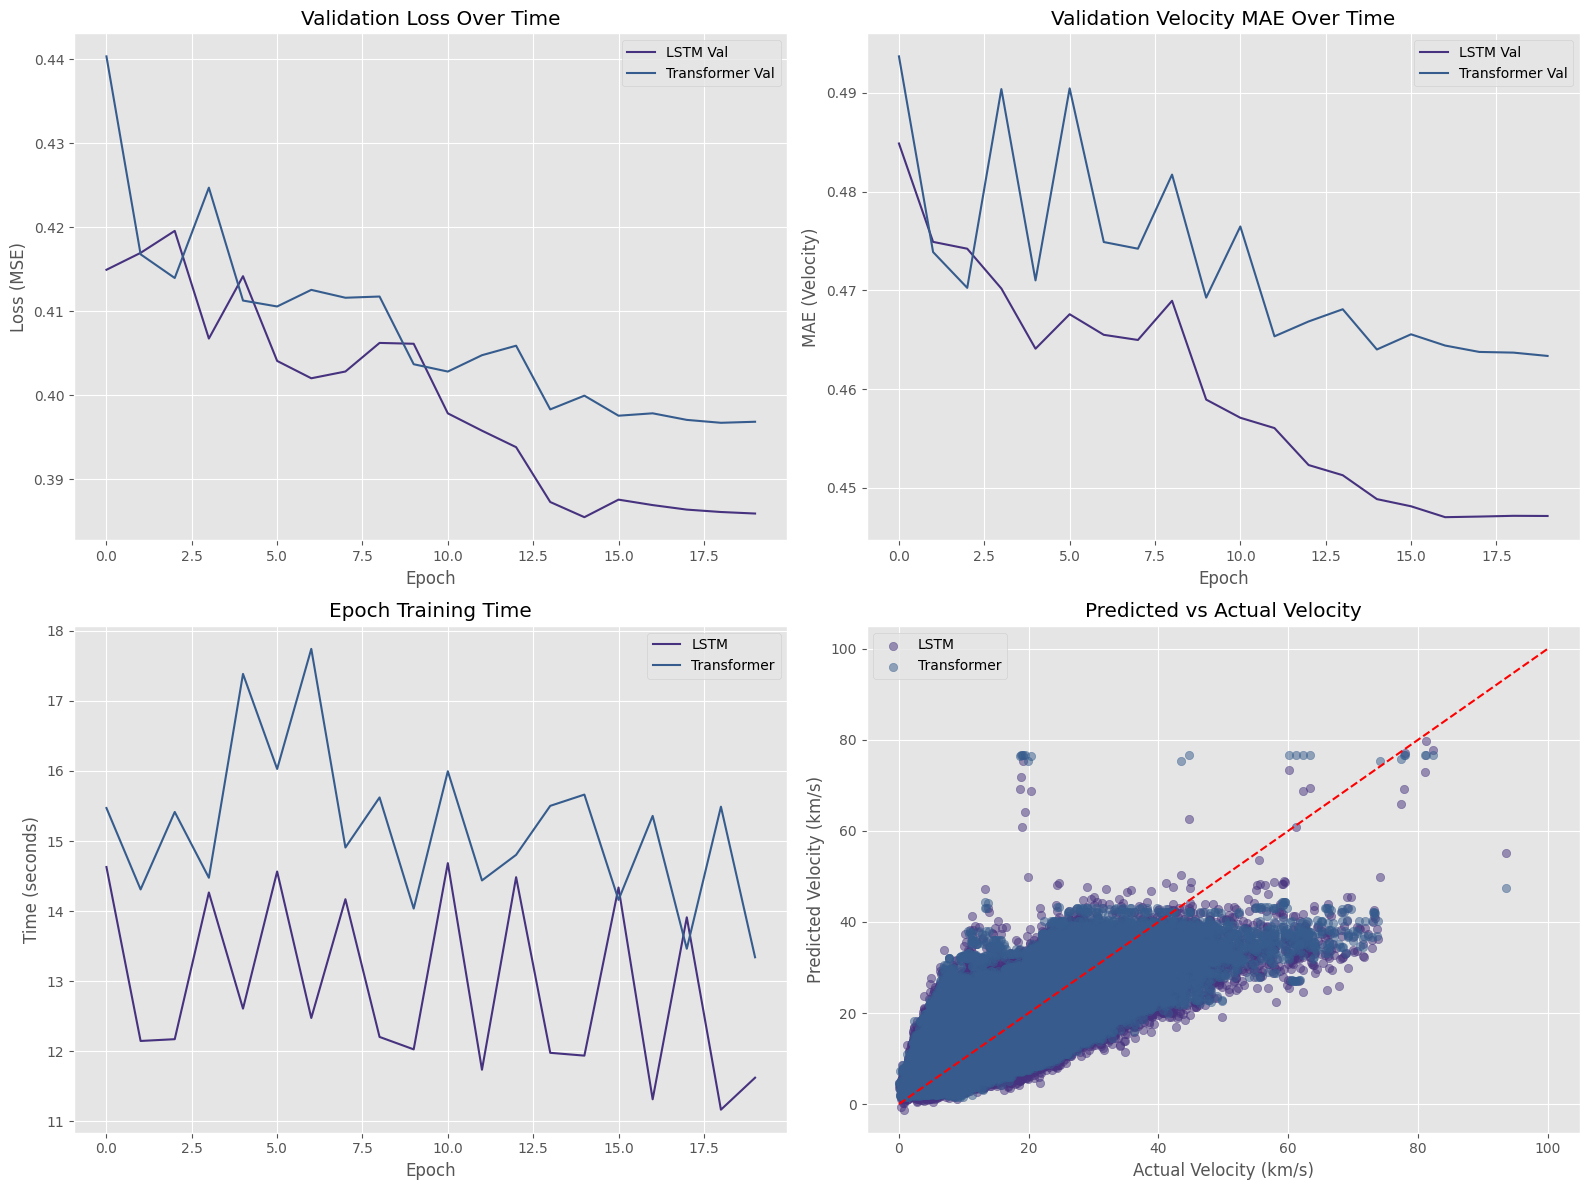

In [68]:
# Visualize validation training history and compare models

print("\nCreating comparison visualizations (validation metrics only)...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot validation loss for both models
axes[0, 0].plot(lstm_history['val_loss'], label='LSTM Val')
axes[0, 0].plot(transformer_history['val_loss'], label='Transformer Val')
axes[0, 0].set_title('Validation Loss Over Time')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot validation MAE for velocity for both models
axes[0, 1].plot(lstm_history['val_mae_velocity'], label='LSTM Val')
axes[0, 1].plot(transformer_history['val_mae_velocity'], label='Transformer Val')
axes[0, 1].set_title('Validation Velocity MAE Over Time')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE (Velocity)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot epoch times
axes[1, 0].plot(lstm_history['epoch_times'], label='LSTM')
axes[1, 0].plot(transformer_history['epoch_times'], label='Transformer')
axes[1, 0].set_title('Epoch Training Time')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot predictions vs actual for velocity
axes[1, 1].scatter(
    lstm_targets_original[:, 0], 
    lstm_preds_original[:, 0], 
    alpha=0.5, 
    label='LSTM'
)
axes[1, 1].scatter(
    transformer_targets_original[:, 0], 
    transformer_preds_original[:, 0], 
    alpha=0.5, 
    label='Transformer'
)
axes[1, 1].plot([0, 100], [0, 100], 'r--')  # Identity line for reference
axes[1, 1].set_title('Predicted vs Actual Velocity')
axes[1, 1].set_xlabel('Actual Velocity (km/s)')
axes[1, 1].set_ylabel('Predicted Velocity (km/s)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'model_comparison.png', dpi=300)
plt.show()


In [69]:
print("\nCreating comparison table...")

metrics_df = pd.DataFrame({
    'Metric': ['MAE Velocity (km/s)', 'RMSE Velocity (km/s)', 'R² Velocity'],
    'LSTM': [lstm_mae_velocity, lstm_rmse_velocity, lstm_r2_velocity],
    'Transformer': [transformer_mae_velocity, transformer_rmse_velocity, transformer_r2_velocity]
})

# Calculate difference and determine which model is better
metrics_df['Difference (%)'] = (metrics_df['Transformer'] - metrics_df['LSTM']) / metrics_df['LSTM'] * 100
metrics_df['Better Model'] = metrics_df.apply(
    lambda row: 'LSTM' if row['Metric'].startswith('R²') and row['LSTM'] > row['Transformer'] else
               'Transformer' if row['Metric'].startswith('R²') and row['Transformer'] > row['LSTM'] else
               'LSTM' if row['Difference (%)'] > 0 else 'Transformer',
    axis=1
)

# Display the comparison table
print("\nModel Comparison Table:")
pd.set_option('display.float_format', '{:.6f}'.format)
print(metrics_df)

# Save the comparison table to CSV
metrics_df.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)

# Save additional prediction data for further analysis
prediction_data = pd.DataFrame({
    'Actual_Velocity': lstm_targets_original[:, 0],
    'LSTM_Predicted_Velocity': lstm_preds_original[:, 0],
    'Transformer_Predicted_Velocity': transformer_preds_original[:, 0]
})

prediction_data.to_csv(RESULTS_DIR / 'prediction_details.csv', index=False)

print("\nTraining and evaluation completed! Results saved to the 'results' directory.")



Creating comparison table...

Model Comparison Table:
                 Metric     LSTM  Transformer  Difference (%) Better Model
0   MAE Velocity (km/s) 3.946649     3.914877       -0.805029  Transformer
1  RMSE Velocity (km/s) 5.410583     5.300778       -2.029452  Transformer
2           R² Velocity 0.606296     0.622114        2.608936  Transformer

Training and evaluation completed! Results saved to the 'results' directory.


# NEO Velocity Prediction Model Deployment

This deployment package contains:
- **Models**:
  - `lstm_model.pt`: The best LSTM-based model (state dictionary) for predicting NEO relative velocity.
  - `transformer_model.pt`: The best Transformer-based model (state dictionary) for predicting NEO relative velocity.
- **Test Data Sample**:
  - `inference_sample.json`: A sample of test data (scaled) for running inferences.
- **Documentation**:
  - This README file.

## Input Specifications

### Sequence Data (Temporal Features)
- **Input Shape**: `[batch_size, seq_length, num_seq_features]`
  - Example: For `seq_length = 2` and 6 features per step, shape is `[batch_size, 2, 6]`.
- **Features** (each sequence step):
  - `miss_distance_au`: Miss distance in astronomical units (AU). Range depends on NEO properties.
  - `relative_velocity_kps`: Relative velocity in km/s. Typically between 0 and 30 km/s (may vary).
  - `approach_year`: Year of the approach.
  - `approach_month`: Month of the approach.
  - `approach_day`: Day of the approach.
  - `day_of_year`: Day of the year (1-366).

### Static NEO Features
- **Input Shape**: `[batch_size, num_features]`
- These include orbital parameters, absolute magnitude, diameter estimates, etc.
- All static features are normalized using a StandardScaler.

## Target Specifications

- **Output**: Predicted relative velocity (km/s) for the next NEO approach.
- **Output Shape**: `[batch_size, 1]`
- The output value represents the predicted relative velocity in km/s.
- The target values are normalized using a StandardScaler.

## Inference

To perform inference:
1. Load the saved model state dictionaries.
2. Load the corresponding scalers if needed.
3. Pass a batch of sequence data and static features to the model.
4. The provided `inference_sample.json` includes an example test input.

### Example (LSTM model):

```python
import torch
from your_model_file import NEOVelocityLSTM  # Replace with your actual model file name

model = NEOVelocityLSTM(seq_input_size, feature_size)
model.load_state_dict(torch.load('lstm_model.pt'))
model.eval()

In [74]:
# Define deployment directory
DEPLOY_DIR = Path("aws_deployment")
DEPLOY_DIR.mkdir(parents=True, exist_ok=True)

# Save both models (state dictionaries)
torch.save(lstm_model.state_dict(), DEPLOY_DIR / 'lstm_model.pt')
torch.save(transformer_model.state_dict(), DEPLOY_DIR / 'transformer_model.pt')
print("Models saved.")

# Save a sample of test data for inference
# Here we save the first 10 samples from the scaled test data and corresponding NEO IDs.
inference_sample = {
    "X_test_sample": X_test_scaled[:10].tolist(),
    "y_test_sample": y_test_scaled[:10].tolist(),
    "test_neo_ids_sample": test_neo_ids[:10]
}
with open(DEPLOY_DIR / 'inference_sample.json', 'w') as f:
    json.dump(inference_sample, f, indent=2)
print("Inference sample saved.")


Models saved.
Inference sample saved.


In [75]:
# Define the feature names (order must match the columns in your input sequence)
feature_names = ['miss_distance_au', 'relative_velocity_kps', 'approach_year', 
                 'approach_month', 'approach_day', 'day_of_year']

# --- Original Features Statistics ---
# Flatten X_train so that each row is one time step
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
df_features = pd.DataFrame(X_train_flat, columns=feature_names)
stats_original = df_features.agg(['min', 'max', 'median']).transpose()

print("Input Feature Statistics (Original Scale):")
print(stats_original)

# --- Scaled Features Statistics ---
# Flatten scaled X_train; it has the same shape as X_train
X_train_scaled_flat = X_train_scaled.reshape(-1, X_train_scaled.shape[-1])
df_features_scaled = pd.DataFrame(X_train_scaled_flat, columns=feature_names)
stats_scaled = df_features_scaled.agg(['min', 'max', 'median']).transpose()

print("\nInput Feature Statistics (Scaled):")
print(stats_scaled)

# Combine both statistics into a single dictionary
all_stats = {
    "original": stats_original.to_dict(),
    "scaled": stats_scaled.to_dict()
}

# Define the deployment directory (create if not exists)
DEPLOY_DIR = Path("aws_deployment")
DEPLOY_DIR.mkdir(parents=True, exist_ok=True)

# Save the statistics as a JSON file for reference (e.g., for the README)
with open(DEPLOY_DIR / 'input_feature_stats.json', 'w') as f:
    json.dump(all_stats, f, indent=2)

print("\nFeature statistics (original and scaled) saved to:", DEPLOY_DIR / 'input_feature_stats.json')


Input Feature Statistics (Original Scale):
                              min         max      median
miss_distance_au         0.000196    1.999592    0.255113
relative_velocity_kps    0.126503   83.256402   14.810265
approach_year         1899.000000 2019.000000 1959.000000
approach_month           1.000000   12.000000    7.000000
approach_day             1.000000   31.000000   16.000000
day_of_year              1.000000  366.000000  184.000000

Input Feature Statistics (Scaled):
                            min      max    median
miss_distance_au      -1.055820 6.236614 -0.126059
relative_velocity_kps -1.858337 7.848179 -0.143813
approach_year         -1.818847 1.804688 -0.007080
approach_month        -1.605995 1.568991  0.125816
approach_day          -1.679566 1.731813  0.026123
day_of_year           -1.731836 1.714513 -0.003940

Feature statistics (original and scaled) saved to: aws_deployment/input_feature_stats.json


In [78]:
# Save the scalers for deployment
print("Saving scalers for deployment...")
import joblib

# Create the deployment directory if it doesn't exist yet
DEPLOY_DIR = Path("aws_deployment")
DEPLOY_DIR.mkdir(parents=True, exist_ok=True)

# Save the scalers
joblib.dump(seq_scaler, DEPLOY_DIR / 'seq_scaler.joblib')
joblib.dump(target_scaler, DEPLOY_DIR / 'target_scaler.joblib')
joblib.dump(feature_scaler, DEPLOY_DIR / 'feature_scaler.joblib')

print("Scalers saved to the aws_deployment directory")

# Also save a simple metadata file with input/output information
metadata = {
    "sequence_length": X_train.shape[1],
    "num_features": X_train.shape[2],
    "target_dims": y_train.shape[1],
    "feature_names": feature_names,
    "model_names": ["lstm", "transformer"]
}

with open(DEPLOY_DIR / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
    
print("Model metadata saved")

Saving scalers for deployment...
Scalers saved to the aws_deployment directory
Model metadata saved


In [79]:
!pip freeze

anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
async-lru==2.0.5
attrs==25.3.0
babel==2.17.0
beautifulsoup4==4.13.3
bleach==6.2.0
certifi==2025.1.31
cffi==1.17.1
charset-normalizer==3.4.1
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.13
decorator==5.2.1
defusedxml==0.7.1
executing==2.2.0
fastjsonschema==2.21.1
filelock==3.18.0
fonttools==4.56.0
fqdn==1.5.1
fsspec==2025.3.0
h11==0.14.0
httpcore==1.0.7
httpx==0.28.1
idna==3.10
ipykernel==6.29.5
ipython==9.0.2
ipython_pygments_lexers==1.1.1
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.6
joblib==1.4.2
json5==0.10.0
jsonpointer==3.0.0
jsonschema==4.23.0
jsonschema-specifications==2024.10.1
jupyter-events==0.12.0
jupyter-lsp==2.2.5
jupyter_client==8.6.3
jupyter_core==5.7.2
jupyter_server==2.15.0
jupyter_server_terminals==0.5.3
jupyterlab==4.3.6
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.3
kiwisolver==1.4.8
MarkupSafe==3.0.2
matplotlib==3.10.1
matplotlib-inline==0.1.7
mistune==3.